# 018 - Sklearn DuckDB SQL Clustering (Customer Segmentation)

This notebook demonstrates **complete batch ML training** for E-Commerce Customer Interactions (ECCI) clustering using:

1. **DuckDB SQL** for data loading and preprocessing from Delta Lake
2. **KMeans / MiniBatchKMeans** as primary models (best for customer segmentation)
3. **HDBSCAN** as alternative for varying density clusters
4. **All sklearn clustering metrics** for comprehensive evaluation
5. **ALL applicable YellowBrick visualizers** (22 total across 5 categories)

## YellowBrick Visualizers Included

| Category | Visualizers | Count |
|----------|-------------|-------|
| **Clustering** | KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance | 3 |
| **Feature Analysis** | Rank1D, Rank2D, PCA, Manifold, ParallelCoordinates, RadViz, JointPlot | 7 |
| **Target/Cluster Analysis** | ClassBalance, FeatureCorrelation (Pearson), FeatureCorrelation (MI), BalancedBinningReference | 4 |
| **Model Selection** | FeatureImportances, CVScores, LearningCurve, ValidationCurve, (RFECV), (DroppingCurve) | 4+2 |
| **Text Modeling** | FreqDistVisualizer, TSNEVisualizer, UMAPVisualizer, DispersionPlot, WordCorrelationPlot, (PosTagVisualizer) | 5+1 |

**Notes:**
- RFECV and DroppingCurve are available but commented out due to slow execution
- PosTagVisualizer requires pre-tagged corpus (NLTK/spaCy) - skipped for raw search queries
- UMAPVisualizer requires umap-learn package

## Complete YellowBrick Reference (35 total visualizers)

| Category | Total | Applicable to Clustering |
|----------|-------|--------------------------|
| Clustering | 3 | 3 (100%) |
| Feature Analysis | 6 | 6 (100%) |
| Target | 3 | 3 (with pseudo-labels) |
| Model Selection | 6 | 4-6 (with pseudo-labels) |
| Text | 5 | 5 (100%) |
| Classification | 7 | 3-5 (with pseudo-labels) |
| Regression | 4 | 0 (not applicable) |

## Model Selection Rationale

Based on 2024-2025 research for e-commerce customer segmentation:

| Model | Speed | Variable Density | Outlier Handling | Best For |
|-------|-------|------------------|------------------|----------|
| **KMeans** | Fast | No | No | Well-defined segments |
| **MiniBatchKMeans** | Very Fast | No | No | Large datasets, streaming |
| **HDBSCAN** | Moderate | Yes | Yes | Complex customer behaviors |

In [1]:
import duckdb
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from typing import Literal

# Optional: HDBSCAN for density-based clustering
try:
    from hdbscan import HDBSCAN
    HDBSCAN_AVAILABLE = True
except ImportError:
    HDBSCAN_AVAILABLE = False
    print("HDBSCAN not available. Install with: pip install hdbscan")

In [2]:
# =============================================================================
# MINIO / S3 CONFIGURATION
# =============================================================================
MINIO_HOST = "localhost"
MINIO_PORT = "9000"
MINIO_ENDPOINT = f"{MINIO_HOST}:{MINIO_PORT}"
MINIO_ACCESS_KEY = "minioadmin"
MINIO_SECRET_KEY = "minioadmin123"

DELTA_PATHS = {
    "Transaction Fraud Detection": "s3://lakehouse/delta/transaction_fraud_detection",
    "Estimated Time of Arrival": "s3://lakehouse/delta/estimated_time_of_arrival",
    "E-Commerce Customer Interactions": "s3://lakehouse/delta/e_commerce_customer_interactions",
}

In [3]:
# =============================================================================
# DUCKDB CONNECTION SETUP
# =============================================================================
os.environ["AWS_EC2_METADATA_DISABLED"] = "true"

conn = duckdb.connect()
conn.execute("INSTALL delta; LOAD delta;")
conn.execute("INSTALL httpfs; LOAD httpfs;")
conn.execute(f"""
    CREATE SECRET minio_secret (
        TYPE S3,
        KEY_ID '{MINIO_ACCESS_KEY}',
        SECRET '{MINIO_SECRET_KEY}',
        REGION 'us-east-1',
        ENDPOINT '{MINIO_ENDPOINT}',
        URL_STYLE 'path',
        USE_SSL false
    );
""")
print("DuckDB extensions loaded and S3 secret configured")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DuckDB extensions loaded and S3 secret configured


## Feature Definitions

### ECCI Features for Event Clustering

Event-level clustering (same pattern as TFD and ETA):

| Category | Features | Description |
|----------|----------|-------------|
| **Numerical** | price, quantity, time_on_page_seconds, session_event_sequence | Raw numeric values |
| **Categorical** | event_type, product_category, product_id, referrer_url, browser, os | Label-encoded with DENSE_RANK |
| **Temporal** | year, month, day, hour, minute, second | Timestamp components |

This approach clusters **events** (not customers), producing segments like:
- "High-value purchase events"
- "Quick browsing events"
- "Search-driven interactions"

In [4]:
# =============================================================================
# FEATURE DEFINITIONS FOR ECCI CLUSTERING (Event-Level)
# =============================================================================

# Event-level features (same pattern as TFD/ETA)
ECCI_NUMERICAL_FEATURES = [
    "price",
    "quantity",
    "time_on_page_seconds",
    "session_event_sequence",
]

ECCI_CATEGORICAL_FEATURES = [
    "event_type",
    "product_category",
    "product_id",
    "referrer_url",
    "browser",
    "os",
    # Timestamp components
    "year",
    "month",
    "day",
    "hour",
    "minute",
    "second",
]

ECCI_ALL_FEATURES = ECCI_NUMERICAL_FEATURES + ECCI_CATEGORICAL_FEATURES
ECCI_CAT_FEATURE_INDICES = list(range(len(ECCI_NUMERICAL_FEATURES), len(ECCI_ALL_FEATURES)))

print(f"Numerical features: {len(ECCI_NUMERICAL_FEATURES)}")
print(f"Categorical features: {len(ECCI_CATEGORICAL_FEATURES)}")
print(f"Total features: {len(ECCI_ALL_FEATURES)}")
print(f"Categorical indices: {ECCI_CAT_FEATURE_INDICES}")

Numerical features: 4
Categorical features: 12
Total features: 16
Categorical indices: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


## Data Loading with DuckDB SQL

Two data loading functions:
1. **Event-level data** - For clustering (main training data) - uses DENSE_RANK encoding like TFD/ETA
2. **Raw event data with text** - For text analysis (search_query field)

In [5]:
def load_event_data(
    delta_path: str,
    sample_frac: float | None = None,
    max_rows: int | None = None,
) -> pd.DataFrame:
    """
    Load ECCI event-level data using DuckDB SQL with DENSE_RANK encoding.
    
    Same pattern as TFD and ETA - no CTE, no aggregation.
    Each row is one event.
    
    Args:
        delta_path: Path to Delta Lake table
        sample_frac: Optional fraction to sample (0.0-1.0)
        max_rows: Optional maximum number of rows
    
    Returns:
        DataFrame with one row per event, all numeric features
    """
    query = f"""
    SELECT
        -- Numerical features
        COALESCE(price, 0) AS price,
        COALESCE(quantity, 0) AS quantity,
        COALESCE(time_on_page_seconds, 0) AS time_on_page_seconds,
        COALESCE(session_event_sequence, 0) AS session_event_sequence,
        
        -- Categorical features: Label encoded with DENSE_RANK() - 1
        DENSE_RANK() OVER (ORDER BY event_type) - 1 AS event_type,
        DENSE_RANK() OVER (ORDER BY COALESCE(product_category, 'unknown')) - 1 AS product_category,
        DENSE_RANK() OVER (ORDER BY COALESCE(product_id, 'unknown')) - 1 AS product_id,
        DENSE_RANK() OVER (ORDER BY COALESCE(referrer_url, 'unknown')) - 1 AS referrer_url,
        DENSE_RANK() OVER (ORDER BY COALESCE(device_info->>'browser', 'unknown')) - 1 AS browser,
        DENSE_RANK() OVER (ORDER BY COALESCE(device_info->>'os', 'unknown')) - 1 AS os,
        
        -- Timestamp components (already integers)
        CAST(date_part('year', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS year,
        CAST(date_part('month', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS month,
        CAST(date_part('day', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS day,
        CAST(date_part('hour', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS hour,
        CAST(date_part('minute', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS minute,
        CAST(date_part('second', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS second
        
    FROM delta_scan('{delta_path}')
    """
    
    # Add sampling clause
    if sample_frac is not None and 0 < sample_frac < 1:
        query += f" USING SAMPLE {sample_frac * 100}%"
    
    # Add limit clause
    if max_rows:
        query += f" LIMIT {max_rows}"
    
    print(f"Loading event-level data (DENSE_RANK encoding)...")
    if sample_frac:
        print(f"  Sampling: {sample_frac * 100}%")
    if max_rows:
        print(f"  Max rows: {max_rows}")
    
    df = conn.execute(query).df()
    print(f"  Loaded {len(df):,} events with {len(df.columns)} columns")
    print(f"  All features numeric: {df.select_dtypes(include=['number']).shape[1]}/{df.shape[1]} columns")
    return df

In [6]:
def load_text_data(
    delta_path: str,
    max_rows: int | None = None,
) -> pd.DataFrame:
    """
    Load raw event data with text fields for text analysis.
    
    Includes search_query for YellowBrick text visualizers.
    
    Args:
        delta_path: Path to Delta Lake table
        max_rows: Optional maximum rows
    
    Returns:
        DataFrame with text columns (search_query, page_url, etc.)
    """
    query = f"""
    SELECT
        customer_id,
        event_type,
        search_query,
        page_url,
        product_category,
        referrer_url
    FROM delta_scan('{delta_path}')
    WHERE search_query IS NOT NULL AND search_query != ''
    """
    
    if max_rows:
        query += f" LIMIT {max_rows}"
    
    print(f"Loading text data (search queries)...")
    df = conn.execute(query).df()
    print(f"  Loaded {len(df):,} search events")
    return df

In [7]:
# =============================================================================
# LOAD DATA
# =============================================================================
MODEL_TYPE = "kmeans"  # "kmeans", "minibatch", or "hdbscan"

# Event-level data for clustering (TRAINING BASELINE)
df = load_event_data(
    DELTA_PATHS["E-Commerce Customer Interactions"],
    max_rows=10000
)

# Text data for text visualizers
df_text = load_text_data(
    DELTA_PATHS["E-Commerce Customer Interactions"],
    max_rows=5000
)

Loading event-level data (DENSE_RANK encoding)...
  Max rows: 10000


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 10,000 events with 16 columns
  All features numeric: 16/16 columns
Loading text data (search queries)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 5,000 search events


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   10000 non-null  float64
 1   quantity                10000 non-null  int32  
 2   time_on_page_seconds    10000 non-null  int32  
 3   session_event_sequence  10000 non-null  int32  
 4   event_type              10000 non-null  int64  
 5   product_category        10000 non-null  int64  
 6   product_id              10000 non-null  int64  
 7   referrer_url            10000 non-null  int64  
 8   browser                 10000 non-null  int64  
 9   os                      10000 non-null  int64  
 10  year                    10000 non-null  int32  
 11  month                   10000 non-null  int32  
 12  day                     10000 non-null  int32  
 13  hour                    10000 non-null  int32  
 14  minute                  10000 non-null 

In [9]:
df.describe()

,price,quantity,time_on_page_seconds,session_event_sequence,event_type,product_category,product_id,referrer_url,browser,os,year,month,day,hour,minute,second
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.000000,10000.000000,10000.000000,10000.000000
mean,1237.788558,0.937900,147.698700,178.041200,1.453900,5.513800,36.729100,13.0,0.0,0.0,2026.0,1.0,16.620500,11.829800,29.329100,29.522900
std,725.624111,1.394216,84.526668,177.374438,1.022634,3.526536,8.780548,0.0,0.0,0.0,0.0,0.0,2.726651,6.844408,17.460231,17.346307
min,0.000000,0.000000,5.000000,2.000000,0.000000,0.000000,29.000000,13.0,0.0,0.0,2026.0,1.0,12.000000,0.000000,0.000000,0.000000
25%,612.547500,0.000000,75.000000,42.000000,0.000000,2.000000,32.000000,13.0,0.0,0.0,2026.0,1.0,14.000000,5.000000,14.000000,15.000000
50%,1235.590000,0.000000,145.000000,115.000000,2.000000,5.000000,35.000000,13.0,0.0,0.0,2026.0,1.0,16.000000,13.000000,29.000000,30.000000
75%,1865.740000,2.000000,220.000000,265.000000,2.000000,9.000000,40.000000,13.0,0.0,0.0,2026.0,1.0,19.000000,18.000000,44.000000,44.000000
max,2499.810000,4.000000,300.000000,860.000000,4.000000,12.000000,101.000000,13.0,0.0,0.0,2026.0,1.0,21.000000,23.000000,59.000000,59.000000


In [10]:
# Preview text data
print("Sample search queries:")
df_text['search_query'].head(20)

Sample search queries:


0                 color statement
1       watch plan concern recent
2                  story research
3                           shake
4                         special
5     control thing reflect thank
6                         believe
7             operation goal note
8        wind until serious serve
9         work around cause every
10             investment he safe
11                 add democratic
12             each late home top
13                     at box its
14                      town find
15                          while
16               lead institution
17                         garden
18                            boy
19      bit animal financial wall
Name: search_query, dtype: object

## Data Preprocessing

In [11]:
def process_data_for_clustering(
    df: pd.DataFrame,
    scale: bool = True,
) -> tuple[pd.DataFrame, np.ndarray, list[str], StandardScaler | None]:
    """
    Process event data for clustering.
    
    Args:
        df: Event-level DataFrame (all columns are features)
        scale: Whether to standardize features
    
    Returns:
        Tuple of (original_df, X_scaled, feature_names, scaler)
    """
    feature_cols = list(df.columns)  # All columns are features
    X = df[feature_cols].copy()
    
    # Handle infinite/NaN values
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Scale features
    scaler = None
    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X.values
    
    print(f"Features: {len(feature_cols)}")
    print(f"Data shape: {X_scaled.shape}")
    
    return df, X_scaled, feature_cols, scaler

df_original, X, feature_names, scaler = process_data_for_clustering(df)

Features: 16
Data shape: (10000, 16)


## Model Creation & Training

In [12]:
def create_clustering_model(
    model_type: Literal["kmeans", "minibatch", "hdbscan"] = "kmeans",
    n_clusters: int = 6,
):
    """
    Create clustering model with optimized hyperparameters.
    
    Hyperparameters based on 2024-2025 customer segmentation research.
    """
    if model_type == "kmeans":
        return KMeans(
            n_clusters=n_clusters,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-4,
            random_state=42,
            algorithm='lloyd',
        )
    elif model_type == "minibatch":
        return MiniBatchKMeans(
            n_clusters=n_clusters,
            init='k-means++',
            n_init=3,
            max_iter=100,
            batch_size=1024,
            max_no_improvement=10,
            random_state=42,
        )
    elif model_type == "hdbscan":
        if not HDBSCAN_AVAILABLE:
            raise ImportError("HDBSCAN not installed")
        return HDBSCAN(
            min_cluster_size=50,
            min_samples=5,
            metric='euclidean',
            cluster_selection_method='eom',
            core_dist_n_jobs=-1,
        )
    raise ValueError(f"Unknown model_type: {model_type}")

In [13]:
def find_optimal_k(X: np.ndarray, k_range: tuple = (2, 10)) -> dict:
    """Find optimal K using multiple metrics."""
    results = {'k': [], 'inertia': [], 'silhouette': [], 'calinski': [], 'davies': []}
    
    for k in range(k_range[0], k_range[1] + 1):
        model = create_clustering_model("kmeans", n_clusters=k)
        labels = model.fit_predict(X)
        
        results['k'].append(k)
        results['inertia'].append(model.inertia_)
        results['silhouette'].append(metrics.silhouette_score(X, labels))
        results['calinski'].append(metrics.calinski_harabasz_score(X, labels))
        results['davies'].append(metrics.davies_bouldin_score(X, labels))
        
        print(f"K={k}: Silhouette={results['silhouette'][-1]:.3f}, CH={results['calinski'][-1]:.0f}, DB={results['davies'][-1]:.3f}")
    
    return results

# Find optimal K
k_results = find_optimal_k(X, k_range=(2, 10))
OPTIMAL_K = k_results['k'][np.argmax(k_results['silhouette'])]
print(f"\nOptimal K (by Silhouette): {OPTIMAL_K}")

K=2: Silhouette=0.153, CH=1510, DB=2.292
K=3: Silhouette=0.116, CH=1217, DB=2.561
K=4: Silhouette=0.122, CH=1220, DB=2.068
K=5: Silhouette=0.127, CH=1123, DB=1.977
K=6: Silhouette=0.126, CH=1011, DB=2.227
K=7: Silhouette=0.121, CH=934, DB=2.176
K=8: Silhouette=0.111, CH=883, DB=2.295
K=9: Silhouette=0.103, CH=821, DB=2.240
K=10: Silhouette=0.102, CH=769, DB=2.291

Optimal K (by Silhouette): 2


In [14]:
# Train final model
final_model = create_clustering_model(MODEL_TYPE, n_clusters=OPTIMAL_K)
cluster_labels = final_model.fit_predict(X)
df_original['cluster'] = cluster_labels

print(f"\nCluster distribution:")
print(df_original['cluster'].value_counts().sort_index())


Cluster distribution:
cluster
0    6944
1    3056
Name: count, dtype: int64


## Sklearn Clustering Metrics

All unsupervised clustering metrics (no ground truth required).

In [15]:
# =============================================================================
# SKLEARN CLUSTERING METRICS
# =============================================================================

clustering_metrics = {
    # Silhouette: [-1, 1], higher is better
    "silhouette_score": (metrics.silhouette_score, {"metric": "euclidean"}),
    # Calinski-Harabasz: [0, inf), higher is better
    "calinski_harabasz_score": (metrics.calinski_harabasz_score, {}),
    # Davies-Bouldin: [0, inf), lower is better
    "davies_bouldin_score": (metrics.davies_bouldin_score, {}),
}

metrics_to_log = {}
print("Clustering Metrics:")
print("="*50)
for name, (fn, kwargs) in clustering_metrics.items():
    value = fn(X, cluster_labels, **kwargs)
    metrics_to_log[name] = value
    print(f"  {name}: {value:.6f}")

# Model-specific metrics
if hasattr(final_model, 'inertia_'):
    metrics_to_log['inertia'] = final_model.inertia_
    print(f"  inertia: {final_model.inertia_:.2f}")

Clustering Metrics:
  silhouette_score: 0.152605
  calinski_harabasz_score: 1509.804663
  davies_bouldin_score: 2.291680
  inertia: 95568.18


## Cluster Profiling

In [16]:
# Cluster profiles
profiles = df_original.groupby('cluster')[feature_names].mean()
profiles['cluster_size'] = df_original.groupby('cluster').size()
profiles['cluster_pct'] = (profiles['cluster_size'] / len(df_original) * 100).round(1)

# Key metrics by cluster (event-level features)
key_cols = ['price', 'quantity', 'time_on_page_seconds', 'event_type', 'cluster_size', 'cluster_pct']
print("Key Metrics by Cluster:")
profiles[key_cols]

Key Metrics by Cluster:


,price,quantity,time_on_page_seconds,event_type,cluster_size,cluster_pct
cluster,,,,,,
0,1237.454423,0.251584,146.068404,2.09375,6944,69.4
1,1238.547798,2.497382,151.403141,0.00000,3056,30.6


---

# YellowBrick Visualizations

Complete set of YellowBrick visualizers applicable to clustering.

## 1. Clustering Visualizers

In [17]:
# =============================================================================
# YELLOWBRICK IMPORTS & COMPATIBILITY FIXES
# =============================================================================
from pathlib import Path
import time

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from yellowbrick.features import Rank1D, Rank2D, PCA, Manifold, ParallelCoordinates, RadViz, JointPlot
from yellowbrick.target import ClassBalance, FeatureCorrelation, BalancedBinningReference

# =============================================================================
# NUMPY 1.22+ COMPATIBILITY FIX FOR YELLOWBRICK INTERCLUSTERDISTANCE
# Issue: YellowBrick uses np.percentile(interpolation=...) but NumPy 1.22+
#        renamed this parameter to 'method'
# Fix: Monkey-patch the percentile_index function in yellowbrick.cluster.icdm
# =============================================================================
import yellowbrick.cluster.icdm as icdm_module

def _patched_percentile_index(a, q):
    """
    Returns the index of the value at the Qth percentile in array a.
    NumPy 1.22+ compatible version using 'method' instead of 'interpolation'.
    """
    try:
        percentile_val = np.percentile(a, q, method="nearest")
    except TypeError:
        percentile_val = np.percentile(a, q, interpolation="nearest")
    return np.where(a == percentile_val)[0][0]

icdm_module.percentile_index = _patched_percentile_index

# Text visualizers
try:
    from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer, DispersionPlot, WordCorrelationPlot
    TEXT_VIS_AVAILABLE = True
except ImportError:
    TEXT_VIS_AVAILABLE = False
    print("Some text visualizers not available")

# =============================================================================
# NUMPY 2.0+ COMPATIBILITY FIX FOR YELLOWBRICK DISPERSIONPLOT
# Issue: YellowBrick uses np.stack(generator) but NumPy 2.0+ requires sequences
# Fix: Monkey-patch DispersionPlot.fit to convert generators to lists
# =============================================================================
if TEXT_VIS_AVAILABLE:
    from yellowbrick.text.dispersion import DispersionPlot as _DispersionPlotClass
    from yellowbrick.exceptions import YellowbrickValueError
    
    def _patched_dispersion_fit(self, X, y=None, **kwargs):
        """
        Patched fit method for NumPy 2.0+ compatibility.
        Converts generators to lists before calling np.stack.
        """
        if y is not None:
            self.classes_ = np.unique(y)
        else:
            self.classes_ = np.array([self.NULL_CLASS])

        # Create an index for the target words
        self.indexed_words_ = np.flip(self.search_terms, axis=0)
        if self.ignore_case:
            self.indexed_words_ = np.array([w.lower() for w in self.indexed_words_])

        # FIX: Convert generator to list before np.stack
        try:
            dispersion_data = list(self._compute_dispersion(X, y))
            if len(dispersion_data) == 0:
                raise ValueError('Empty')
            offsets_positions_categories = np.stack(dispersion_data)
        except ValueError:
            raise YellowbrickValueError('No search terms were found in the corpus')

        # FIX: Convert zip to list before np.stack
        word_positions = np.stack(
            list(zip(
                offsets_positions_categories[:, 0].astype(int),
                offsets_positions_categories[:, 1].astype(int),
            ))
        )

        self.word_categories_ = offsets_positions_categories[:, 2]
        self._check_missing_words(word_positions)
        self.draw(word_positions, **kwargs)
        return self
    
    # Apply the patch
    _DispersionPlotClass.fit = _patched_dispersion_fit

# =============================================================================
# OUTPUT DIRECTORY FOR YELLOWBRICK VISUALIZATIONS
# =============================================================================
YELLOWBRICK_PATH = Path("models/yellowbrick/ecci")
YELLOWBRICK_PATH.mkdir(parents=True, exist_ok=True)

# Create subdirectories
(YELLOWBRICK_PATH / "clustering").mkdir(exist_ok=True)
(YELLOWBRICK_PATH / "feature_analysis").mkdir(exist_ok=True)
(YELLOWBRICK_PATH / "target_analysis").mkdir(exist_ok=True)
(YELLOWBRICK_PATH / "text_analysis").mkdir(exist_ok=True)

print(f"✓ YellowBrick InterclusterDistance patched for NumPy 1.22+ compatibility")
print(f"✓ YellowBrick DispersionPlot.fit patched for NumPy 2.0+ compatibility")
print(f"✓ Output directory: {YELLOWBRICK_PATH.absolute()}")

✓ YellowBrick InterclusterDistance patched for NumPy 1.22+ compatibility
✓ YellowBrick DispersionPlot.fit patched for NumPy 2.0+ compatibility
✓ Output directory: /home/rafaelcoelho/Workbench/COELHORealTime/notebooks/models/yellowbrick/ecci


In [18]:
# =============================================================================
# YELLOWBRICK CLUSTERING KWARGS & VISUALIZERS
# Reference: https://www.scikit-yb.org/en/latest/api/cluster/index.html
# =============================================================================

def yellowbrick_clustering_kwargs(verbose=True):
    """
    Generate kwargs for ALL YellowBrick clustering visualizers.
    
    ALL Visualizers:
    | Visualizer           | Description                    | Speed    |
    |----------------------|--------------------------------|----------|
    | KElbowVisualizer     | Find optimal K (elbow method)  | MODERATE |
    | SilhouetteVisualizer | Per-cluster silhouette scores  | FAST     |
    | InterclusterDistance | Cluster separation (MDS/t-SNE) | MODERATE |
    
    Kwargs Optimization Notes:
    - KElbowVisualizer: k=(2,12) covers typical customer segment range
    - SilhouetteVisualizer: colors='yellowbrick' for consistent palette
    - InterclusterDistance: embedding='mds' is faster, 'tsne' better separation
    
    Returns:
        dict: Dictionary of visualizer name -> kwargs
    """
    kwargs = {
        # =================================================================
        # KElbowVisualizer - Find optimal K
        # Docs: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
        # Metrics: 'distortion' (sum squared distances to centroid)
        #          'silhouette' (cohesion vs separation, -1 to 1)
        #          'calinski_harabasz' (ratio of between/within cluster variance)
        # Best for ECCI: 'silhouette' - interpretable score, handles imbalanced clusters
        # =================================================================
        "KElbowVisualizer": {
            "k": (2, 12),                    # Range of K to test (typical for customer segments)
            "metric": "silhouette",          # Best for interpretability
            "timings": True,                 # Show computation time per K
            "locate_elbow": True,            # Auto-detect elbow point
            "force_model": True,             # Required for sklearn 1.4+ compatibility
        },
        
        # =================================================================
        # SilhouetteVisualizer - Per-cluster quality
        # Docs: https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html
        # Shows silhouette coefficient for each sample, grouped by cluster
        # Good clusters: uniform thickness, score > 0.5
        # =================================================================
        "SilhouetteVisualizer": {
            "colors": "yellowbrick",         # Color palette (consistent across visualizers)
            "is_fitted": False,              # Will fit during visualization
            "force_model": True,             # Required for sklearn 1.4+ compatibility
        },
        
        # =================================================================
        # InterclusterDistance - Cluster separation visualization
        # Docs: https://www.scikit-yb.org/en/latest/api/cluster/icdm.html
        # Embeddings: 'mds' (faster, linear), 'tsne' (slower, non-linear, better separation)
        # Best for ECCI: 'mds' for speed; use 'tsne' for publication-quality
        # =================================================================
        "InterclusterDistance": {
            "embedding": "mds",              # 'mds' faster, 'tsne' better separation
            "legend": True,
            "legend_loc": "lower left",
            "force_model": True,             # Required for sklearn 1.4+ compatibility
        },
    }
    
    if verbose:
        print("=" * 60)
        print("YellowBrick Clustering Visualizers (ECCI)")
        print("=" * 60)
        for name, kw in kwargs.items():
            metric = kw.get('metric', kw.get('embedding', 'N/A'))
            print(f"  {name}: {metric}")
    
    return kwargs


def execute_clustering_visualizers(
    kwargs: dict,
    X: np.ndarray,
    n_clusters: int,
    trained_model=None,
    verbose=True
):
    """
    Execute all clustering visualizers and save to disk.
    
    Args:
        kwargs: Output from yellowbrick_clustering_kwargs()
        X: Feature matrix (scaled)
        n_clusters: Number of clusters for SilhouetteVisualizer and InterclusterDistance
        trained_model: Optional pre-trained model (used for Silhouette/InterclusterDistance)
        verbose: Print progress
        
    Returns:
        list: Results with status, timing, and output paths
    """
    results = []
    
    for name, kw in kwargs.items():
        status = "SUCCESS"
        error_msg = None
        output_path = None
        start_time = time.time()
        
        if verbose:
            print(f"  {name}... ", end="", flush=True)
        
        try:
            fig, ax = plt.subplots(figsize=(10, 8))
            
            if name == "KElbowVisualizer":
                # KElbow must create fresh models to test different K values
                visualizer = KElbowVisualizer(KMeans(random_state=42), ax=ax, **kw)
                visualizer.fit(X)
            elif name == "SilhouetteVisualizer":
                # Use trained model if provided, otherwise create new one
                model = trained_model if trained_model else KMeans(n_clusters=n_clusters, random_state=42)
                is_fitted = trained_model is not None
                kw_copy = {k: v for k, v in kw.items() if k != "is_fitted"}
                visualizer = SilhouetteVisualizer(model, ax=ax, is_fitted=is_fitted, **kw_copy)
                visualizer.fit(X)
            elif name == "InterclusterDistance":
                # Use trained model if provided, otherwise create new one
                model = trained_model if trained_model else KMeans(n_clusters=n_clusters, random_state=42)
                visualizer = InterclusterDistance(model, ax=ax, **kw)
                visualizer.fit(X)
            else:
                raise ValueError(f"Unknown visualizer: {name}")
            
            visualizer.show()
            output_path = f"{YELLOWBRICK_PATH}/clustering/{name}.png"
            visualizer.fig.savefig(output_path, dpi=150, bbox_inches="tight")
            plt.clf()
            plt.close('all')
            
            if verbose:
                print(f"OK ({time.time() - start_time:.1f}s)")
                
        except Exception as e:
            status = "FAILED"
            error_msg = str(e)
            plt.close('all')
            if verbose:
                print(f"FAILED: {error_msg}")
        
        results.append({
            "name": name,
            "status": status,
            "time": time.time() - start_time,
            "output": output_path,
            "error": error_msg,
        })
    
    return results


# Generate kwargs
clustering_kwargs = yellowbrick_clustering_kwargs(verbose=True)

YellowBrick Clustering Visualizers (ECCI)
  KElbowVisualizer: silhouette
  SilhouetteVisualizer: N/A
  InterclusterDistance: mds



Executing Clustering Visualizers:
----------------------------------------
  KElbowVisualizer... 

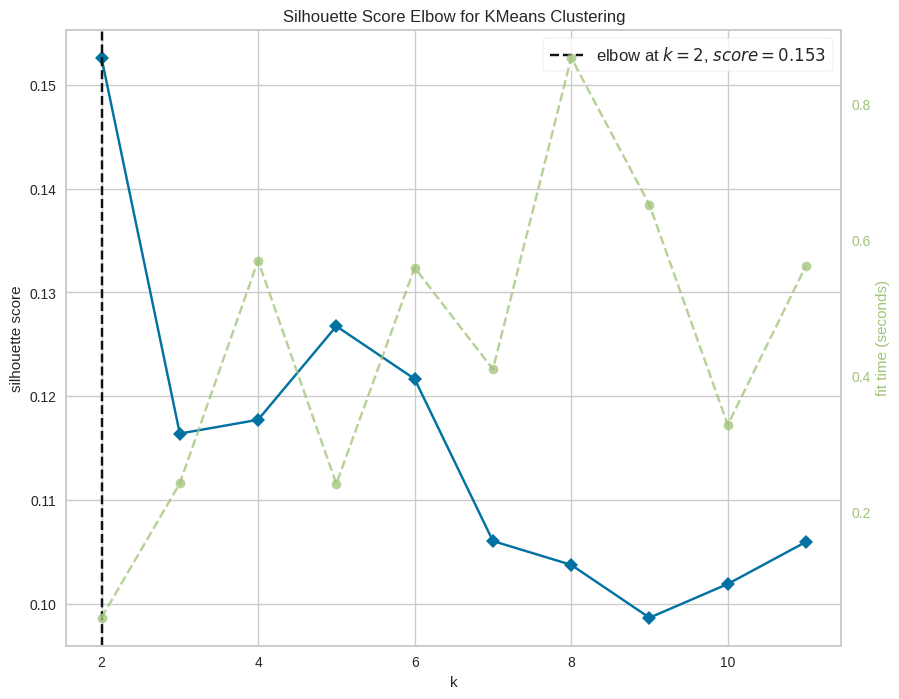

OK (28.4s)
  SilhouetteVisualizer... 

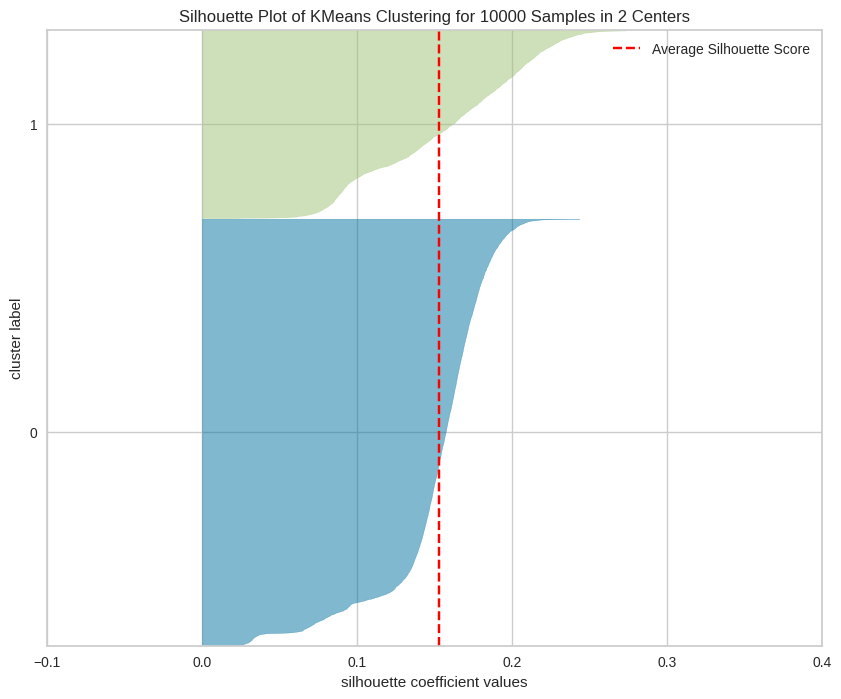

OK (5.0s)
  InterclusterDistance... 

/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(


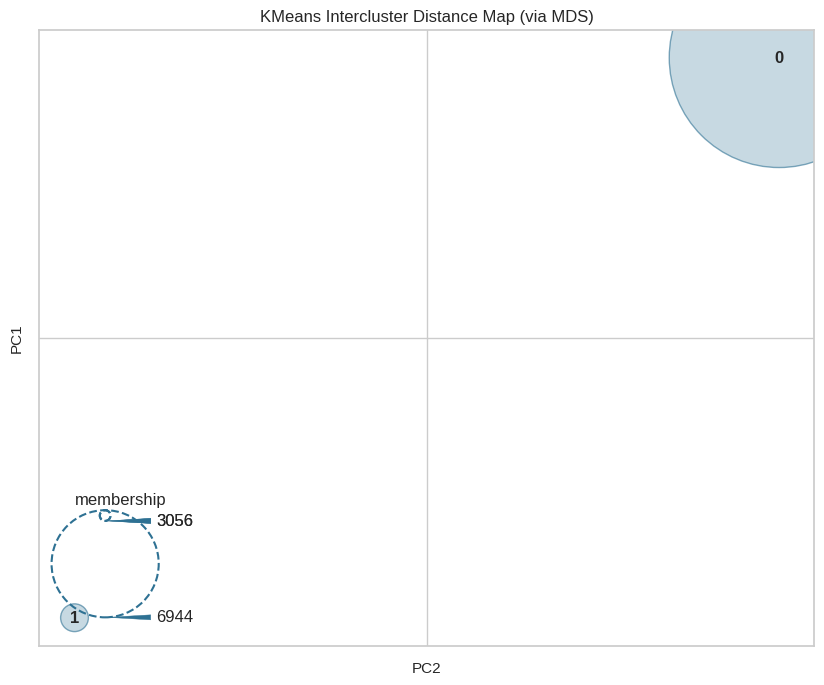

OK (0.5s)


In [19]:
# Execute clustering visualizers with the trained final_model
print("\nExecuting Clustering Visualizers:")
print("-" * 40)
clustering_results = execute_clustering_visualizers(
    clustering_kwargs, 
    X, 
    n_clusters=OPTIMAL_K, 
    trained_model=final_model,  # Pass the trained model for consistency
    verbose=True
)

In [20]:
# Show clustering results summary
print("\nClustering Visualizers Summary:")
print("-" * 40)
for r in clustering_results:
    status_icon = "✓" if r["status"] == "SUCCESS" else "✗"
    print(f"  {status_icon} {r['name']}: {r['status']} ({r['time']:.1f}s)")
    if r["output"]:
        print(f"      → {r['output']}")


Clustering Visualizers Summary:
----------------------------------------
  ✓ KElbowVisualizer: SUCCESS (28.4s)
      → models/yellowbrick/ecci/clustering/KElbowVisualizer.png
  ✓ SilhouetteVisualizer: SUCCESS (5.0s)
      → models/yellowbrick/ecci/clustering/SilhouetteVisualizer.png
  ✓ InterclusterDistance: SUCCESS (0.5s)
      → models/yellowbrick/ecci/clustering/InterclusterDistance.png


## 2. Feature Analysis Visualizers

Feature analysis visualizers help understand relationships between features:

| Visualizer | Description | Clustering Context |
|------------|-------------|-------------------|
| **Rank1D** | Single feature ranking (Shapiro normality) | Identify non-normal features |
| **Rank2D** | Pairwise feature correlation | Detect multicollinearity |
| **PCA** | 2D projection via Principal Components | Visualize cluster separation |
| **ParallelCoordinates** | Multi-dimensional data view | Compare feature profiles across clusters |
| **RadViz** | Radial visualization | Quick separability check |
| **JointPlot** | Bivariate distribution | Explore specific feature pairs |

Reference: https://www.scikit-yb.org/en/latest/api/features/index.html

In [21]:
# =============================================================================
# YELLOWBRICK FEATURE ANALYSIS KWARGS & VISUALIZERS
# Reference: https://www.scikit-yb.org/en/latest/api/features/index.html
# =============================================================================

def yellowbrick_feature_kwargs(features, classes, verbose=True):
    """
    Generate kwargs for ALL YellowBrick feature analysis visualizers.
    
    ALL Visualizers:
    | Visualizer          | Description                        | Speed    |
    |---------------------|------------------------------------|----------|
    | Rank1D              | Single feature ranking (Shapiro)   | FAST     |
    | Rank2D              | Pairwise correlation matrix        | FAST     |
    | PCA                 | 2D/3D PCA projection               | FAST     |
    | ParallelCoordinates | Multi-dimensional lines            | FAST     |
    | RadViz              | Radial visualization               | FAST     |
    | JointPlot           | Bivariate distribution             | FAST     |
    | Manifold            | t-SNE/UMAP projection              | SLOW     |
    
    Kwargs Optimization Notes:
    - Rank1D: 'shapiro' detects non-normal features (may need log transform)
    - Rank2D: 'pearson' for linear, 'spearman' for non-linear relationships
    - PCA: scale=False since data is already scaled
    - Manifold: t-SNE best for cluster visualization (perplexity affects results)
    - ParallelCoordinates/RadViz: Limited to 10 features for readability
    
    Args:
        features: List of feature names
        classes: List of class/cluster names
        
    Returns:
        dict: Dictionary of visualizer name -> kwargs
    """
    kwargs = {
        # =================================================================
        # Rank1D - Single feature ranking using Shapiro-Wilk normality test
        # Docs: https://www.scikit-yb.org/en/latest/api/features/rankd.html
        # Algorithms: 'shapiro' (normality), 'variance' (feature variance)
        # Best for ECCI: 'shapiro' - identifies features needing transformation
        # =================================================================
        "Rank1D": {
            "algorithm": "shapiro",          # 'shapiro' for normality, 'variance' for spread
            "features": features,
            "orient": "h",                   # Horizontal for readability with many features
            "show_feature_names": True,
        },
        
        # =================================================================
        # Rank2D - Pairwise feature correlation matrix
        # Algorithms: 'pearson' (linear), 'spearman' (rank), 'kendalltau' (ordinal)
        # Best for ECCI: 'pearson' for continuous features; check for multicollinearity
        # =================================================================
        "Rank2D": {
            "algorithm": "pearson",          # Linear correlation
            "features": features,
            "colormap": "RdBu_r",            # Red=positive, Blue=negative
            "show_feature_names": True,
        },
        
        # =================================================================
        # PCA - Principal Component Analysis 2D/3D projection
        # Docs: https://www.scikit-yb.org/en/latest/api/features/pca.html
        # scale=False since data is already StandardScaler'd
        # projection=2 for 2D; use 3 for interactive 3D
        # =================================================================
        "PCA": {
            "scale": False,                  # Already scaled with StandardScaler
            "projection": 2,                 # 2D projection (3 for 3D)
            "proj_features": False,          # Don't project feature vectors
            "classes": classes,
            "alpha": 0.75,                   # Point transparency
        },
        
        # =================================================================
        # Manifold - Non-linear dimensionality reduction (t-SNE)
        # Docs: https://www.scikit-yb.org/en/latest/api/features/manifold.html
        # Algorithms: 'lle', 'ltsa', 'hessian', 'modified', 'isomap', 'mds', 'spectral', 'tsne'
        # Best for ECCI: 'tsne' preserves local cluster structure
        # Note: Uses sklearn.manifold.TSNE defaults (perplexity=30, learning_rate='auto')
        # =================================================================
        "Manifold": {
            "manifold": "tsne",              # t-SNE best for clustering visualization
            "classes": classes,
            "n_neighbors": 10,               # For LLE/Isomap (not used by t-SNE)
        },
        
        # =================================================================
        # ParallelCoordinates - Multi-dimensional data visualization
        # Docs: https://www.scikit-yb.org/en/latest/api/features/pcoords.html
        # Useful for seeing how feature values differ across clusters
        # Limited to 10 features for readability
        # =================================================================
        "ParallelCoordinates": {
            "classes": classes,
            "features": features[:10],       # Limit for readability
            "normalize": "standard",         # Standardize for comparison
            "shuffle": True,                 # Shuffle for overlapping lines
            "alpha": 0.5,                    # Transparency for overlaps
        },
        
        # =================================================================
        # RadViz - Radial visualization for high-dimensional data
        # Docs: https://www.scikit-yb.org/en/latest/api/features/radviz.html
        # Features arranged in a circle; points pulled toward high values
        # Good for quick visual check of separability
        # =================================================================
        "RadViz": {
            "classes": classes,
            "features": features[:10],       # Limit for readability
            "alpha": 0.5,
        },
        
        # =================================================================
        # JointPlot - Bivariate feature distribution
        # Docs: https://www.scikit-yb.org/en/latest/api/features/jointplot.html
        # Shows scatter + marginal distributions for 2 features
        # NOTE: Uses integer column indices for numpy arrays (not strings)
        # Default: price (idx 0) vs quantity (idx 1)
        # =================================================================
        "JointPlot": {
            "columns": [0, 1],               # Integer indices (price, quantity)
            "alpha": 0.5,
        },
    }
    
    if verbose:
        print("=" * 60)
        print("YellowBrick Feature Analysis Visualizers (ECCI)")
        print("=" * 60)
        for name, kw in kwargs.items():
            algo = kw.get('algorithm', kw.get('manifold', kw.get('projection', 'N/A')))
            print(f"  {name}: {algo}")
    
    return kwargs


def execute_feature_visualizers(
    kwargs: dict,
    X: np.ndarray,
    y: np.ndarray,
    feature_names: list,
    verbose=True
):
    """
    Execute all feature analysis visualizers and save to disk.
    
    Args:
        kwargs: Output from yellowbrick_feature_kwargs()
        X: Feature matrix (scaled)
        y: Cluster labels
        feature_names: List of feature names (for JointPlot labels)
        verbose: Print progress
        
    Returns:
        list: Results with status, timing, and output paths
    """
    results = []
    
    for name, kw in kwargs.items():
        status = "SUCCESS"
        error_msg = None
        output_path = None
        start_time = time.time()
        
        if verbose:
            print(f"  {name}... ", end="", flush=True)
        
        try:
            fig, ax = plt.subplots(figsize=(12, 10) if name in ["Rank1D", "Rank2D"] else (10, 8))
            
            if name == "Rank1D":
                visualizer = Rank1D(ax=ax, **kw)
                visualizer.fit_transform(X)
            elif name == "Rank2D":
                visualizer = Rank2D(ax=ax, **kw)
                visualizer.fit_transform(X)
            elif name == "PCA":
                visualizer = PCA(ax=ax, **kw)
                visualizer.fit_transform(X, y)
            elif name == "Manifold":
                # Manifold is SLOW - use sample for large datasets
                X_sample = X[:2000] if len(X) > 2000 else X
                y_sample = y[:2000] if len(y) > 2000 else y
                visualizer = Manifold(ax=ax, **kw)
                visualizer.fit_transform(X_sample, y_sample)
            elif name == "ParallelCoordinates":
                visualizer = ParallelCoordinates(ax=ax, **kw)
                visualizer.fit_transform(X[:, :10], y)  # Use first 10 features
            elif name == "RadViz":
                visualizer = RadViz(ax=ax, **kw)
                visualizer.fit_transform(X[:, :10], y)  # Use first 10 features
            elif name == "JointPlot":
                # JointPlot needs special handling - use first 2 features
                X_joint = X[:, :2]
                visualizer = JointPlot(
                    columns=[0, 1],  # Integer indices
                    alpha=kw.get("alpha", 0.5),
                    ax=ax
                )
                visualizer.fit_transform(X_joint, y)
            else:
                raise ValueError(f"Unknown visualizer: {name}")
            
            visualizer.show()
            output_path = f"{YELLOWBRICK_PATH}/feature_analysis/{name}.png"
            visualizer.fig.savefig(output_path, dpi=150, bbox_inches="tight")
            plt.clf()
            plt.close('all')
            
            if verbose:
                print(f"OK ({time.time() - start_time:.1f}s)")
                
        except Exception as e:
            status = "FAILED"
            error_msg = str(e)
            plt.close('all')
            if verbose:
                print(f"FAILED: {error_msg}")
        
        results.append({
            "name": name,
            "status": status,
            "time": time.time() - start_time,
            "output": output_path,
            "error": error_msg,
        })
    
    return results


# Classes for visualizers (use cluster labels)
classes = [f"Cluster {i}" for i in range(OPTIMAL_K)]

# Generate kwargs
feature_kwargs = yellowbrick_feature_kwargs(
    features=feature_names,
    classes=classes,
    verbose=True
)

YellowBrick Feature Analysis Visualizers (ECCI)
  Rank1D: shapiro
  Rank2D: pearson
  PCA: 2
  Manifold: tsne
  ParallelCoordinates: N/A
  RadViz: N/A
  JointPlot: N/A



Executing Feature Analysis Visualizers:
----------------------------------------
  Rank1D... 

/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:592: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:592: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


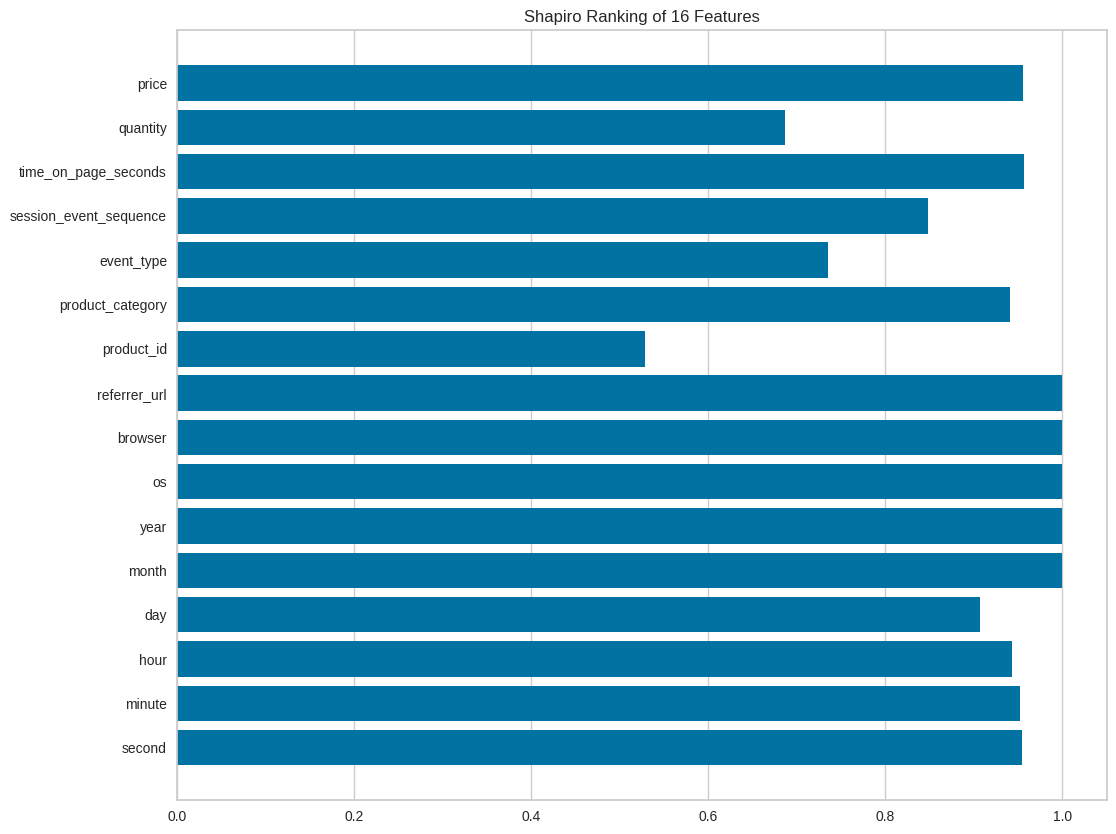

OK (0.6s)
  Rank2D... 

/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


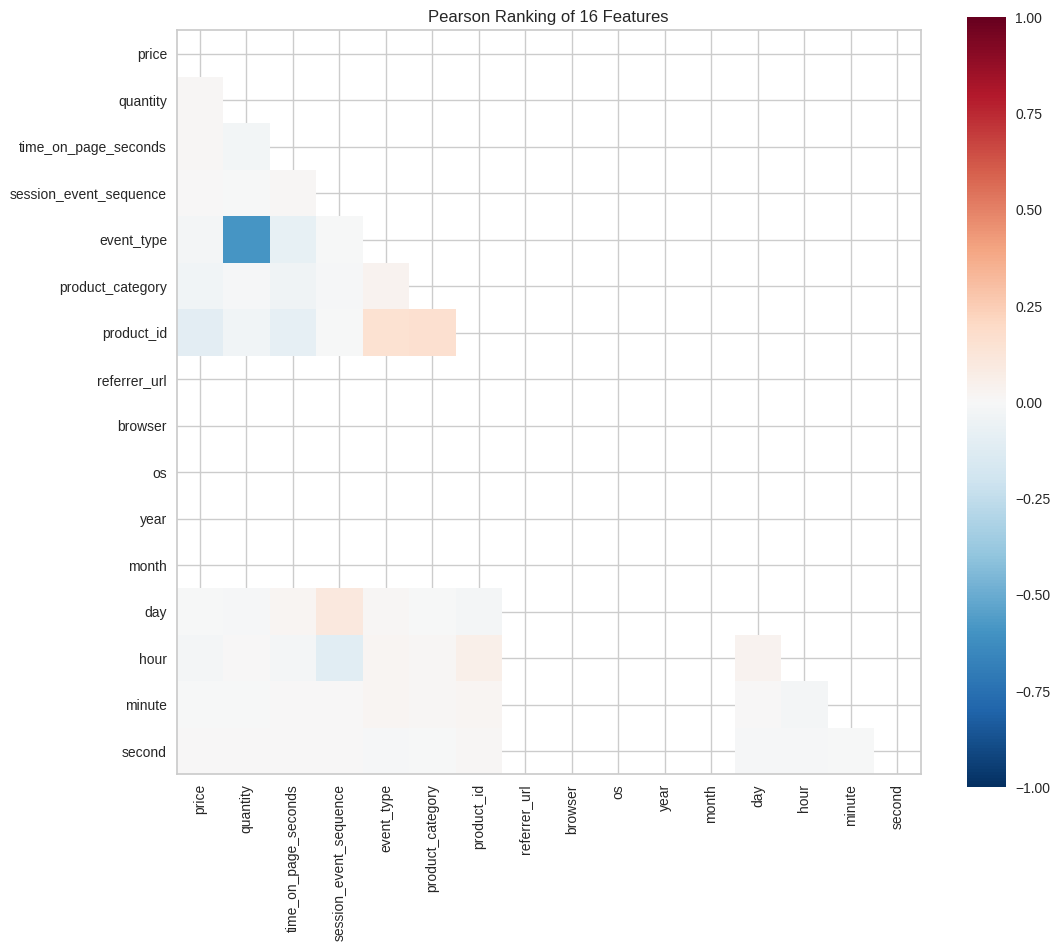

OK (0.8s)
  PCA... 

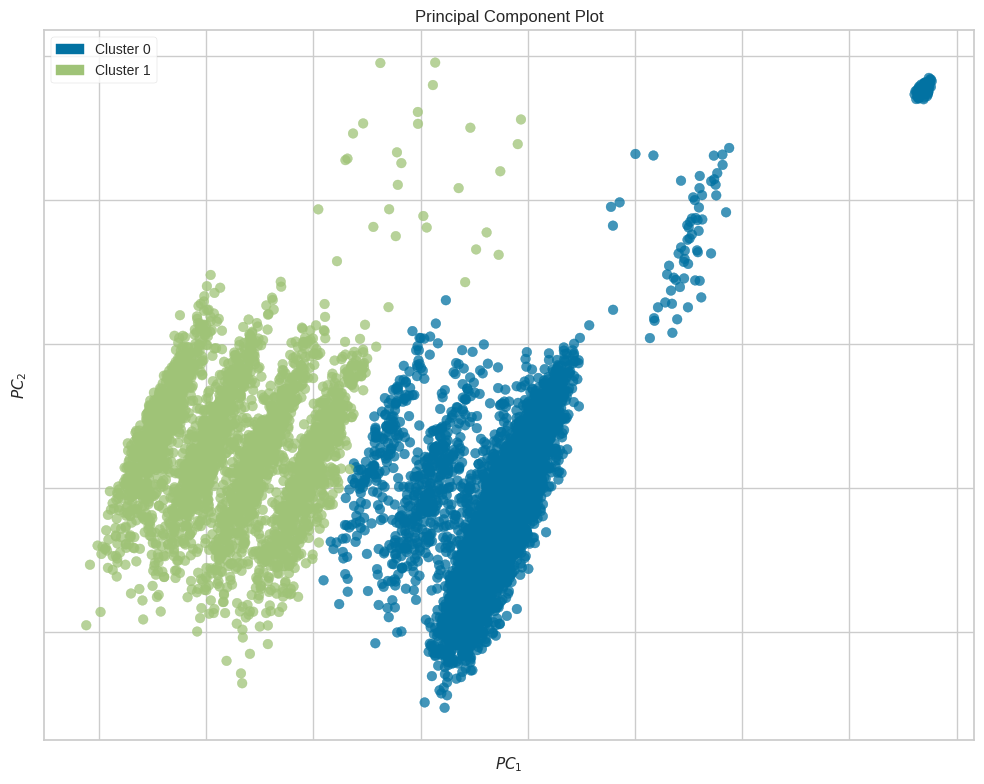

OK (2.8s)
  Manifold... 

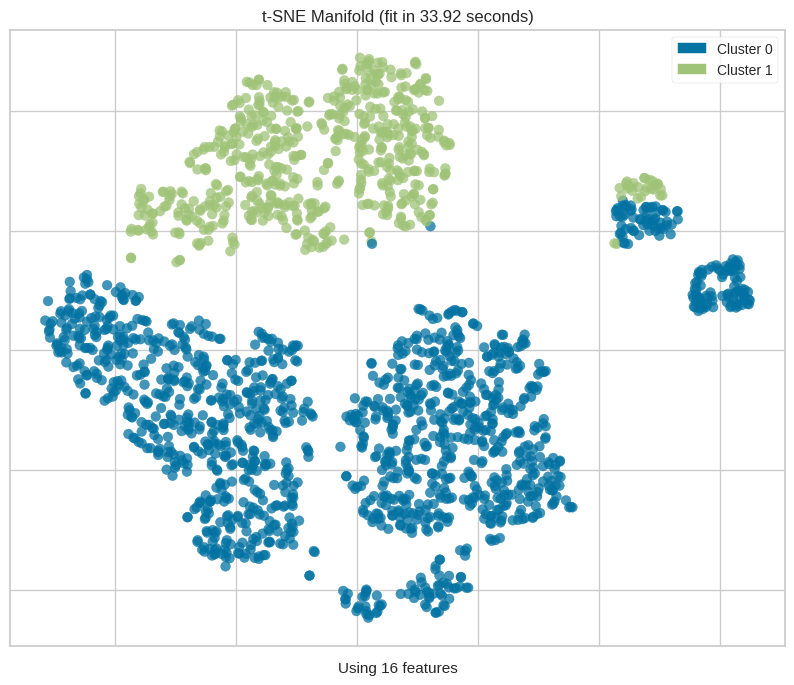

OK (34.5s)
  ParallelCoordinates... 

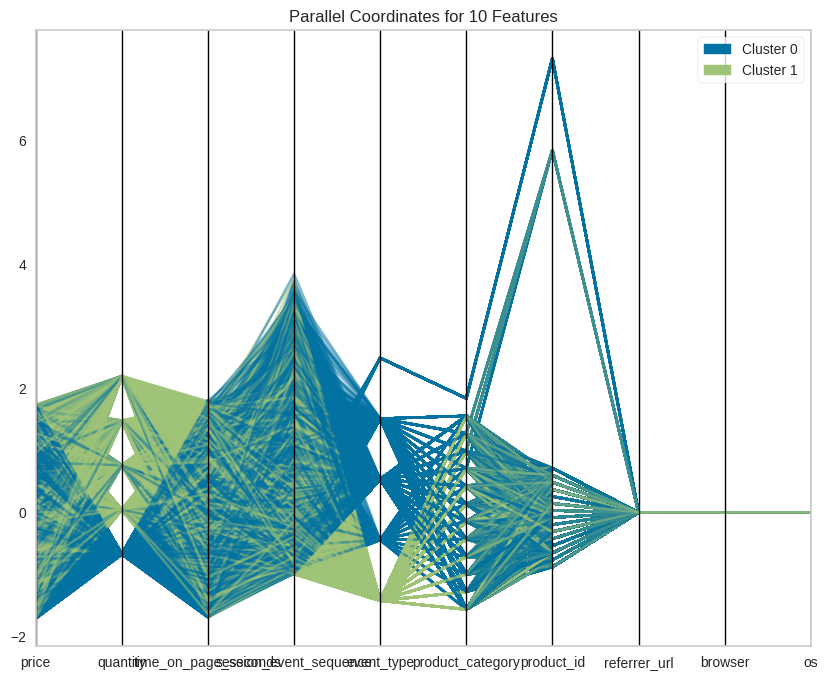

OK (60.6s)
  RadViz... 

/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/yellowbrick/features/radviz.py:134: RuntimeWarning: invalid value encountered in divide
  return (X - a[np.newaxis, :]) / ((b - a)[np.newaxis, :])


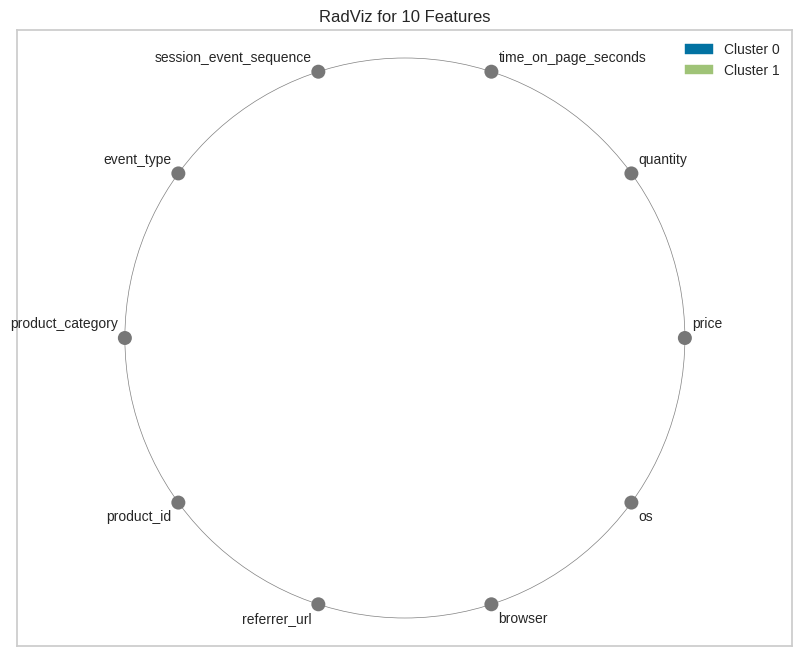

OK (1.4s)
  JointPlot... 

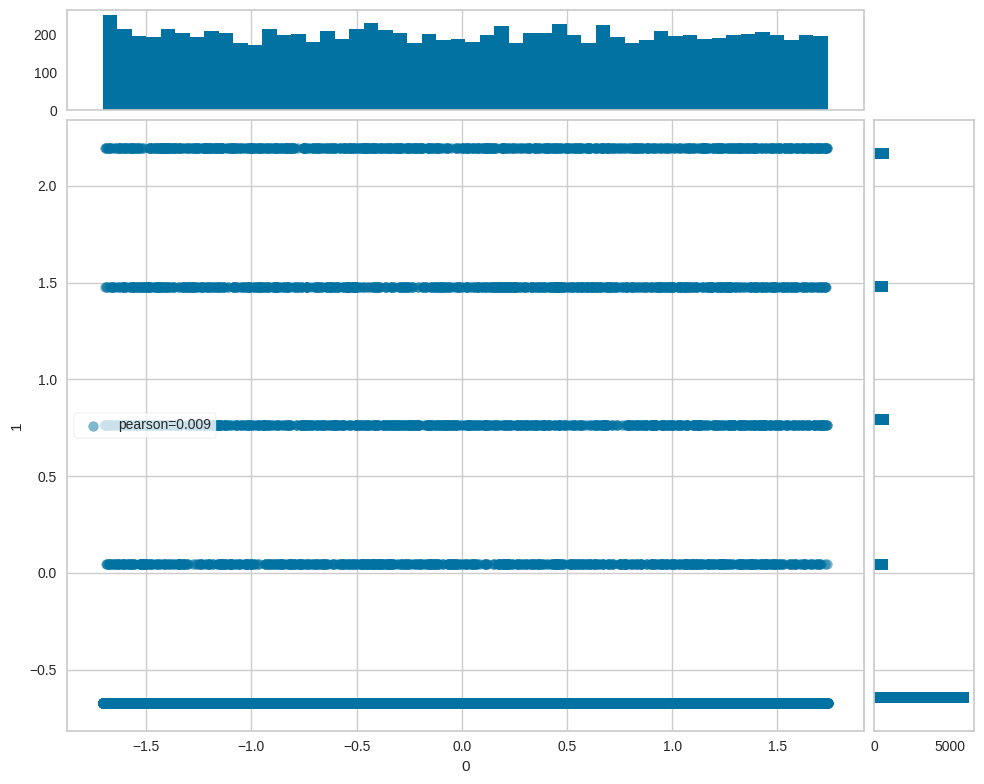

OK (3.1s)

Feature Analysis Visualizers Summary:
----------------------------------------
  ✓ Rank1D: SUCCESS (0.6s)
      → models/yellowbrick/ecci/feature_analysis/Rank1D.png
  ✓ Rank2D: SUCCESS (0.8s)
      → models/yellowbrick/ecci/feature_analysis/Rank2D.png
  ✓ PCA: SUCCESS (2.8s)
      → models/yellowbrick/ecci/feature_analysis/PCA.png
  ✓ Manifold: SUCCESS (34.5s)
      → models/yellowbrick/ecci/feature_analysis/Manifold.png
  ✓ ParallelCoordinates: SUCCESS (60.6s)
      → models/yellowbrick/ecci/feature_analysis/ParallelCoordinates.png
  ✓ RadViz: SUCCESS (1.4s)
      → models/yellowbrick/ecci/feature_analysis/RadViz.png
  ✓ JointPlot: SUCCESS (3.1s)
      → models/yellowbrick/ecci/feature_analysis/JointPlot.png


In [22]:
# Execute feature analysis visualizers
print("\nExecuting Feature Analysis Visualizers:")
print("-" * 40)
feature_results = execute_feature_visualizers(
    feature_kwargs, X, cluster_labels, feature_names, verbose=True
)

# Show results summary
print("\nFeature Analysis Visualizers Summary:")
print("-" * 40)
for r in feature_results:
    status_icon = "✓" if r["status"] == "SUCCESS" else "✗"
    print(f"  {status_icon} {r['name']}: {r['status']} ({r['time']:.1f}s)")
    if r["output"]:
        print(f"      → {r['output']}")

## 3. Target/Cluster Analysis Visualizers

Using cluster labels as pseudo-target for analysis:

| Visualizer | Description | Clustering Context |
|------------|-------------|-------------------|
| **ClassBalance** | Cluster distribution | Visualize cluster sizes |
| **FeatureCorrelation (Pearson)** | Linear correlation with cluster | Quick linear relationships |
| **FeatureCorrelation (MI)** | Mutual info with cluster | Non-linear correlations |
| **BalancedBinningReference** | Feature distribution binning | Understand feature distributions |

Reference: https://www.scikit-yb.org/en/latest/api/target/index.html

In [23]:
# =============================================================================
# YELLOWBRICK TARGET/CLUSTER ANALYSIS KWARGS & VISUALIZERS
# Reference: https://www.scikit-yb.org/en/latest/api/target/index.html
# =============================================================================

def yellowbrick_target_kwargs(features, classes, verbose=True):
    """
    Generate kwargs for ALL YellowBrick target analysis visualizers (clustering).
    
    ALL Visualizers:
    | Visualizer               | Fit Method | Clustering |
    |--------------------------|------------|------------|
    | ClassBalance             | fit(y)     | YES        |
    | FeatureCorrelation       | fit(X, y)  | YES        |
    | BalancedBinningReference | fit(y)     | YES        |
    
    Returns:
        dict: Dictionary of visualizer name -> kwargs
    """
    kwargs = {
        # =================================================================
        # ClassBalance - Cluster distribution
        # Docs: https://www.scikit-yb.org/en/latest/api/target/class_balance.html
        # =================================================================
        "ClassBalance": {
            "labels": classes,
        },
        
        # =================================================================
        # FeatureCorrelation - Pearson (Linear)
        # Docs: https://www.scikit-yb.org/en/latest/api/target/feature_correlation.html
        # =================================================================
        "FeatureCorrelation_Pearson": {
            "method": "pearson",
            "labels": features,
            "sort": True,
            "color": "#4CAF50",
        },
        
        # =================================================================
        # FeatureCorrelation - Mutual Information (Non-linear)
        # Method: "mutual_info-classification" for discrete targets (clusters)
        # =================================================================
        "FeatureCorrelation_MutualInfo": {
            "method": "mutual_info-classification",
            "labels": features,
            "sort": True,
            "color": "#2196F3",
        },
        
        # =================================================================
        # BalancedBinningReference - Feature Distribution
        # Docs: https://www.scikit-yb.org/en/latest/api/target/binning.html
        # =================================================================
        "BalancedBinningReference": {
            "bins": 10,
            "color": "#FF5722",
        },
    }
    
    if verbose:
        print("=" * 60)
        print("YellowBrick Target/Cluster Analysis Visualizers (ECCI)")
        print("=" * 60)
        for name, kw in kwargs.items():
            method = kw.get('method', kw.get('bins', 'N/A'))
            print(f"  {name}: {method}")
    
    return kwargs


def execute_target_visualizers(
    kwargs: dict,
    X: np.ndarray,
    y: np.ndarray,
    feature_names: list,
    verbose=True
):
    """
    Execute all target analysis visualizers and save to disk.
    
    Args:
        kwargs: Output from yellowbrick_target_kwargs()
        X: Feature matrix
        y: Cluster labels
        feature_names: List of feature names
        verbose: Print progress
        
    Returns:
        list: Results with status, timing, and output paths
    """
    results = []
    
    for name, kw in kwargs.items():
        status = "SUCCESS"
        error_msg = None
        output_path = None
        start_time = time.time()
        
        if verbose:
            print(f"  {name}... ", end="", flush=True)
        
        try:
            fig, ax = plt.subplots(figsize=(12, 8) if "FeatureCorrelation" in name else (10, 6))
            
            if name == "ClassBalance":
                visualizer = ClassBalance(ax=ax, **kw)
                visualizer.fit(y)
            elif name == "FeatureCorrelation_Pearson":
                visualizer = FeatureCorrelation(ax=ax, **kw)
                visualizer.fit(X, y)
            elif name == "FeatureCorrelation_MutualInfo":
                visualizer = FeatureCorrelation(ax=ax, **kw)
                visualizer.fit(X, y)
            elif name == "BalancedBinningReference":
                # Use price feature (index 0 in event-level data)
                price_idx = feature_names.index("price")
                visualizer = BalancedBinningReference(ax=ax, **kw)
                visualizer.fit(X[:, price_idx])
            else:
                raise ValueError(f"Unknown visualizer: {name}")
            
            visualizer.show()
            save_name = name.replace("_", "")
            output_path = f"{YELLOWBRICK_PATH}/target_analysis/{save_name}.png"
            visualizer.fig.savefig(output_path, dpi=150, bbox_inches="tight")
            plt.clf()
            plt.close('all')
            
            if verbose:
                print(f"OK ({time.time() - start_time:.1f}s)")
                
        except Exception as e:
            status = "FAILED"
            error_msg = str(e)
            plt.close('all')
            if verbose:
                print(f"FAILED: {error_msg}")
        
        results.append({
            "name": name,
            "status": status,
            "time": time.time() - start_time,
            "output": output_path,
            "error": error_msg,
        })
    
    return results


# Generate kwargs
target_kwargs = yellowbrick_target_kwargs(
    features=feature_names,
    classes=classes,
    verbose=True
)

YellowBrick Target/Cluster Analysis Visualizers (ECCI)
  ClassBalance: N/A
  FeatureCorrelation_Pearson: pearson
  FeatureCorrelation_MutualInfo: mutual_info-classification
  BalancedBinningReference: 10



Executing Target/Cluster Analysis Visualizers:
----------------------------------------
  ClassBalance... 

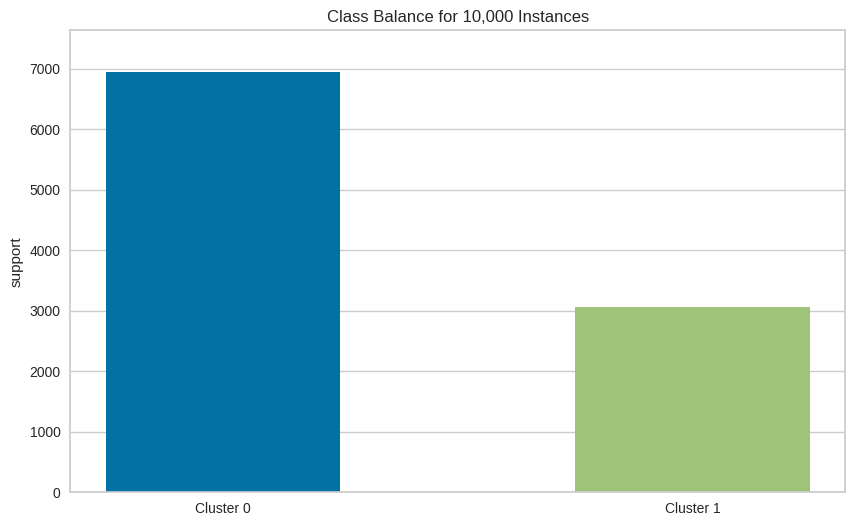

OK (0.5s)
  FeatureCorrelation_Pearson... 

/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/yellowbrick/target/feature_correlation.py:174: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  [pearsonr(x, y, **kwargs)[0] for x in np.asarray(X).T]


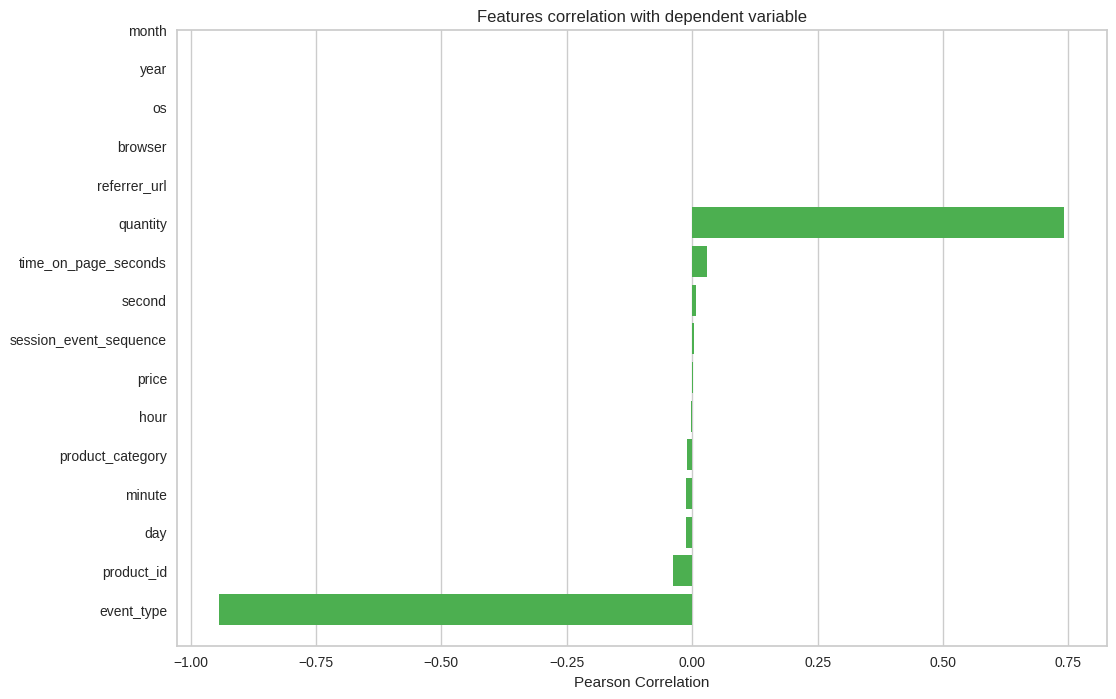

OK (0.8s)
  FeatureCorrelation_MutualInfo... 

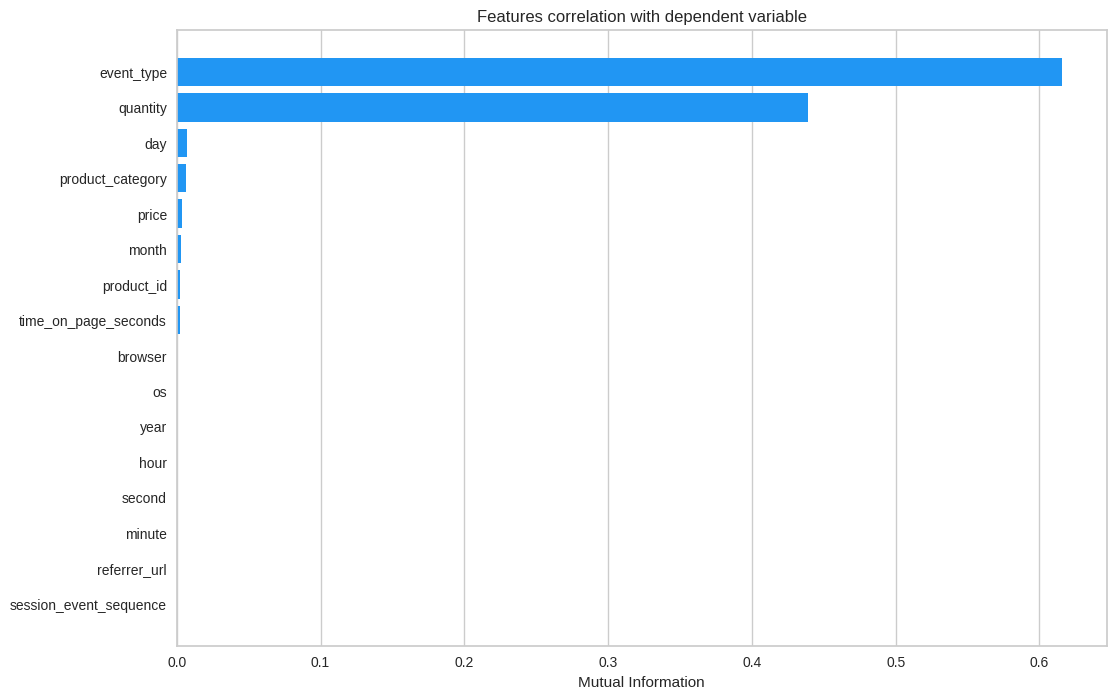

OK (2.5s)
  BalancedBinningReference... 

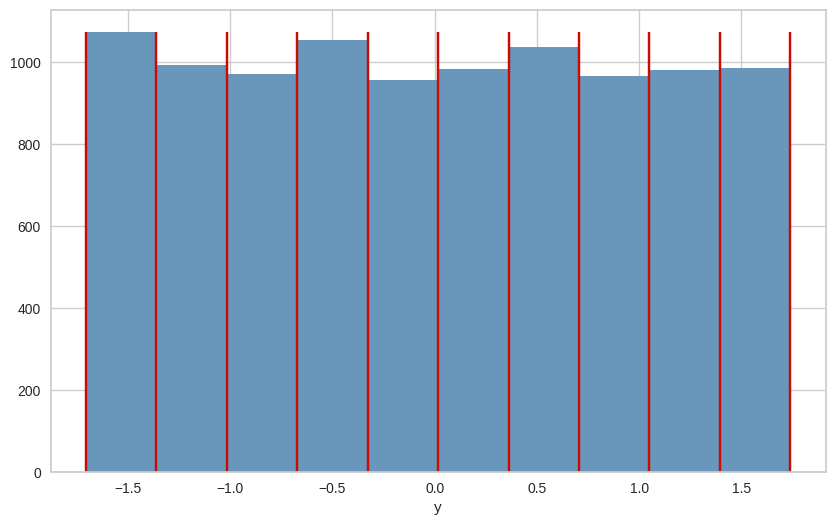

OK (0.4s)

Target/Cluster Analysis Visualizers Summary:
----------------------------------------
  ✓ ClassBalance: SUCCESS (0.5s)
      → models/yellowbrick/ecci/target_analysis/ClassBalance.png
  ✓ FeatureCorrelation_Pearson: SUCCESS (0.8s)
      → models/yellowbrick/ecci/target_analysis/FeatureCorrelationPearson.png
  ✓ FeatureCorrelation_MutualInfo: SUCCESS (2.5s)
      → models/yellowbrick/ecci/target_analysis/FeatureCorrelationMutualInfo.png
  ✓ BalancedBinningReference: SUCCESS (0.4s)
      → models/yellowbrick/ecci/target_analysis/BalancedBinningReference.png


In [24]:
# Execute target analysis visualizers
print("\nExecuting Target/Cluster Analysis Visualizers:")
print("-" * 40)
target_results = execute_target_visualizers(
    target_kwargs, X, cluster_labels, feature_names, verbose=True
)

# Show results summary
print("\nTarget/Cluster Analysis Visualizers Summary:")
print("-" * 40)
for r in target_results:
    status_icon = "✓" if r["status"] == "SUCCESS" else "✗"
    print(f"  {status_icon} {r['name']}: {r['status']} ({r['time']:.1f}s)")
    if r["output"]:
        print(f"      → {r['output']}")

## 4. Model Selection Visualizers

For clustering, we train a classifier to predict cluster labels and use Model Selection visualizers:

| Visualizer | Description | Clustering Context |
|------------|-------------|-------------------|
| **FeatureImportances** | Feature ranking by model | Which features define clusters |
| **CVScores** | Cross-validation scores | Cluster prediction stability |
| **LearningCurve** | Performance vs training size | Data sufficiency |
| **ValidationCurve** | Performance vs hyperparameter | Optimal model complexity |
| **RFECV** | Recursive feature elimination | Optimal feature subset |
| **DroppingCurve** | Performance vs dropped features | Feature robustness |

Reference: https://www.scikit-yb.org/en/latest/api/model_selection/index.html

In [25]:
# =============================================================================
# YELLOWBRICK MODEL SELECTION KWARGS & VISUALIZERS
# Reference: https://www.scikit-yb.org/en/latest/api/model_selection/index.html
# For clustering: Train a classifier to predict cluster labels
# =============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from yellowbrick.model_selection import (
    FeatureImportances, CVScores, LearningCurve, 
    ValidationCurve, RFECV, DroppingCurve
)

# Create output directory
(YELLOWBRICK_PATH / "model_selection").mkdir(exist_ok=True)


def yellowbrick_model_selection_kwargs(features, verbose=True):
    """
    Generate kwargs for ALL YellowBrick model selection visualizers.
    
    For clustering, we use cluster labels as pseudo-targets and train
    a RandomForest classifier to predict them. This reveals:
    - Which features best separate clusters (FeatureImportances)
    - How stable cluster predictions are (CVScores)
    - If more data would help define clusters (LearningCurve)
    - Optimal model complexity for cluster prediction (ValidationCurve)
    
    ALL Visualizers:
    | Visualizer         | Description                    | Speed      |
    |--------------------|--------------------------------|------------|
    | FeatureImportances | Feature ranking by importance  | FAST       |
    | CVScores           | Cross-validation score dist    | MODERATE   |
    | LearningCurve      | Performance vs training size   | SLOW       |
    | ValidationCurve    | Performance vs hyperparameter  | SLOW       |
    | RFECV              | Recursive feature elimination  | VERY SLOW  |
    | DroppingCurve      | Performance vs dropped features| SLOW       |
    
    Kwargs Optimization Notes:
    - FeatureImportances: relative=True shows % contribution
    - CVScores: cv=5 is standard; use stratified for imbalanced clusters
    - LearningCurve: 5 points from 10% to 100% training size
    - ValidationCurve: Tests max_depth 2-10 (tree complexity)
    
    Returns:
        dict: Dictionary of visualizer name -> kwargs
    """
    kwargs = {
        # =================================================================
        # FeatureImportances - Feature ranking by model importance
        # Docs: https://www.scikit-yb.org/en/latest/api/model_selection/importances.html
        # Shows which features RandomForest uses to predict cluster membership
        # relative=True shows percentage contribution (sums to 100%)
        # =================================================================
        "FeatureImportances": {
            "labels": features,
            "relative": True,                # Show percentages
            "absolute": False,
        },
        
        # =================================================================
        # CVScores - Cross-validation score distribution
        # Docs: https://www.scikit-yb.org/en/latest/api/model_selection/cross_validation.html
        # Shows variance in cluster prediction accuracy across folds
        # Tight distribution = stable clusters; wide = clusters overlap
        # =================================================================
        "CVScores": {
            "cv": 5,                         # 5-fold cross-validation (standard)
            "scoring": "accuracy",           # Could use 'f1_weighted' for imbalanced
        },
        
        # =================================================================
        # LearningCurve - Performance vs training size
        # Docs: https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html
        # Shows if more data would help define clusters better
        # Converging curves = enough data; diverging = need more samples
        # =================================================================
        "LearningCurve": {
            "train_sizes": np.linspace(0.1, 1.0, 5),  # 10%, 32.5%, 55%, 77.5%, 100%
            "cv": 3,                         # 3-fold for speed
            "scoring": "accuracy",
            "random_state": 42,
        },
        
        # =================================================================
        # ValidationCurve - Performance vs hyperparameter
        # Docs: https://www.scikit-yb.org/en/latest/api/model_selection/validation_curve.html
        # Tests tree depth: shallow=underfitting, deep=overfitting
        # Sweet spot where train/test curves are closest
        # =================================================================
        "ValidationCurve": {
            "param_name": "max_depth",       # Tree depth (complexity)
            "param_range": np.array([2, 4, 6, 8, 10]),  # Typical range
            "cv": 3,
            "scoring": "accuracy",
        },
        
        # =================================================================
        # RFECV - Recursive Feature Elimination with CV (VERY SLOW)
        # Docs: https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html
        # Finds optimal feature subset by recursively removing features
        # Commented out by default due to slow execution (~5-10 min)
        # =================================================================
        # "RFECV": {
        #     "cv": 3,
        #     "scoring": "accuracy",
        #     "step": 1,                     # Remove 1 feature per iteration
        # },
        
        # =================================================================
        # DroppingCurve - Performance vs dropped features (SLOW)
        # Docs: https://www.scikit-yb.org/en/latest/api/model_selection/dropping_curve.html
        # Tests robustness by randomly dropping feature subsets
        # Commented out by default due to slow execution
        # =================================================================
        # "DroppingCurve": {
        #     "cv": 3,
        #     "scoring": "accuracy",
        # },
    }
    
    if verbose:
        print("=" * 60)
        print("YellowBrick Model Selection Visualizers (ECCI)")
        print("=" * 60)
        for name, kw in kwargs.items():
            print(f"  {name}: cv={kw.get('cv', 'N/A')}, scoring={kw.get('scoring', 'N/A')}")
    
    return kwargs


def execute_model_selection_visualizers(
    kwargs: dict,
    X: np.ndarray,
    y: np.ndarray,
    feature_names: list,
    verbose=True
):
    """
    Execute all model selection visualizers and save to disk.
    
    Args:
        kwargs: Output from yellowbrick_model_selection_kwargs()
        X: Feature matrix
        y: Cluster labels (used as pseudo-target)
        feature_names: List of feature names
        verbose: Print progress
        
    Returns:
        list: Results with status, timing, and output paths
    """
    results = []
    
    # Split data for some visualizers
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    for name, kw in kwargs.items():
        status = "SUCCESS"
        error_msg = None
        output_path = None
        start_time = time.time()
        
        if verbose:
            print(f"  {name}... ", end="", flush=True)
        
        try:
            fig, ax = plt.subplots(figsize=(12, 8) if name == "FeatureImportances" else (10, 6))
            
            if name == "FeatureImportances":
                # Use pre-fitted model
                model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
                model.fit(X_train, y_train)
                visualizer = FeatureImportances(model, ax=ax, **kw)
                visualizer.fit(X_train, y_train)
            elif name == "CVScores":
                model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
                visualizer = CVScores(model, ax=ax, **kw)
                visualizer.fit(X, y)
            elif name == "LearningCurve":
                model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
                visualizer = LearningCurve(model, ax=ax, **kw)
                visualizer.fit(X, y)
            elif name == "ValidationCurve":
                model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
                visualizer = ValidationCurve(model, ax=ax, **kw)
                visualizer.fit(X, y)
            elif name == "RFECV":
                model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
                visualizer = RFECV(model, ax=ax, **kw)
                visualizer.fit(X, y)
            elif name == "DroppingCurve":
                model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
                visualizer = DroppingCurve(model, ax=ax, **kw)
                visualizer.fit(X, y)
            else:
                raise ValueError(f"Unknown visualizer: {name}")
            
            visualizer.show()
            output_path = f"{YELLOWBRICK_PATH}/model_selection/{name}.png"
            visualizer.fig.savefig(output_path, dpi=150, bbox_inches="tight")
            plt.clf()
            plt.close('all')
            
            if verbose:
                print(f"OK ({time.time() - start_time:.1f}s)")
                
        except Exception as e:
            status = "FAILED"
            error_msg = str(e)
            plt.close('all')
            if verbose:
                print(f"FAILED: {error_msg}")
        
        results.append({
            "name": name,
            "status": status,
            "time": time.time() - start_time,
            "output": output_path,
            "error": error_msg,
        })
    
    return results


# Generate kwargs
model_selection_kwargs = yellowbrick_model_selection_kwargs(
    features=feature_names,
    verbose=True
)

YellowBrick Model Selection Visualizers (ECCI)
  FeatureImportances: cv=N/A, scoring=N/A
  CVScores: cv=5, scoring=accuracy
  LearningCurve: cv=3, scoring=accuracy
  ValidationCurve: cv=3, scoring=accuracy



Executing Model Selection Visualizers:
----------------------------------------
  FeatureImportances... 

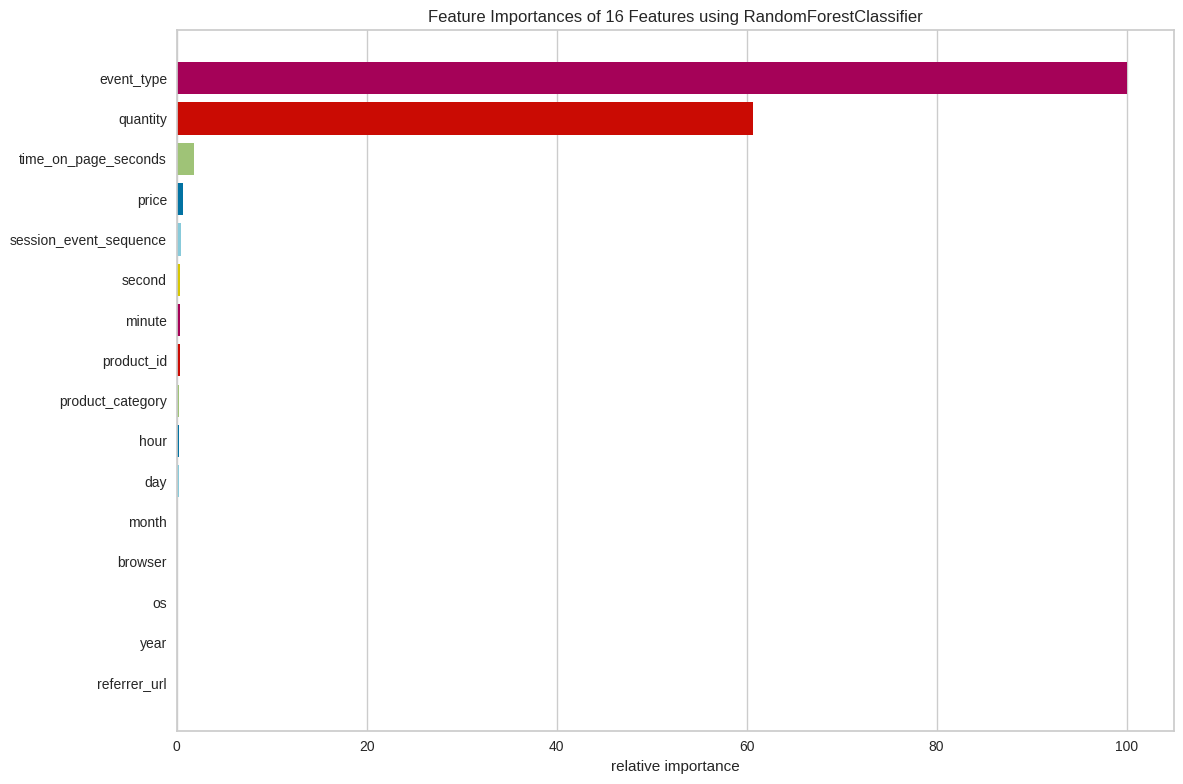

OK (2.3s)
  CVScores... 

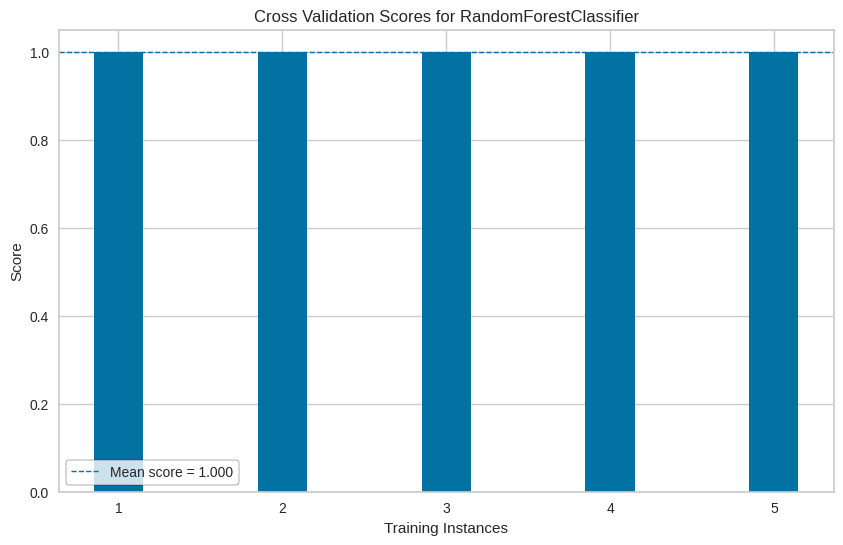

OK (3.1s)
  LearningCurve... 

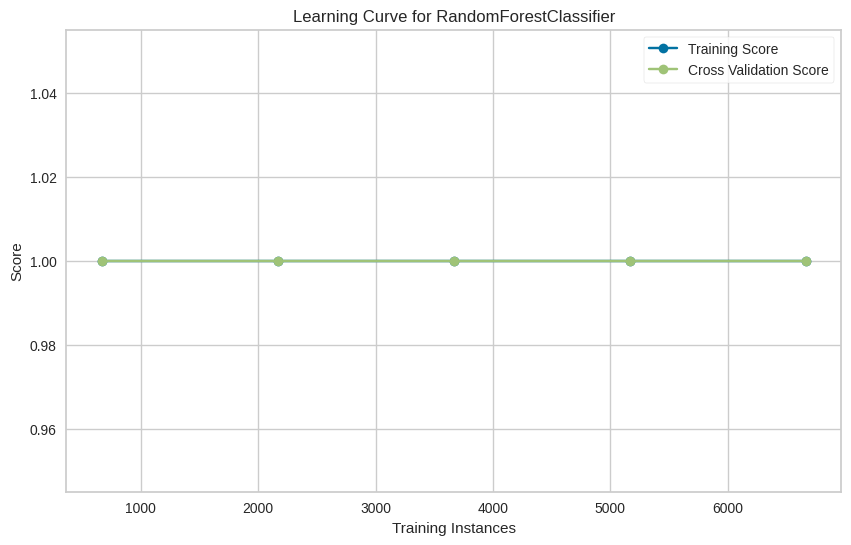

OK (21.5s)
  ValidationCurve... 

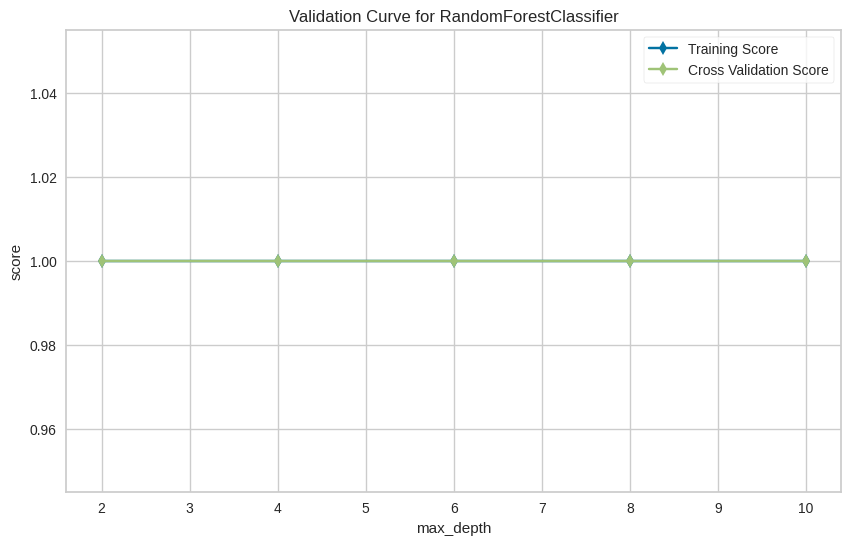

OK (4.9s)

Model Selection Visualizers Summary:
----------------------------------------
  ✓ FeatureImportances: SUCCESS (2.3s)
      → models/yellowbrick/ecci/model_selection/FeatureImportances.png
  ✓ CVScores: SUCCESS (3.1s)
      → models/yellowbrick/ecci/model_selection/CVScores.png
  ✓ LearningCurve: SUCCESS (21.5s)
      → models/yellowbrick/ecci/model_selection/LearningCurve.png
  ✓ ValidationCurve: SUCCESS (4.9s)
      → models/yellowbrick/ecci/model_selection/ValidationCurve.png


In [26]:
# Execute model selection visualizers
print("\nExecuting Model Selection Visualizers:")
print("-" * 40)
model_selection_results = execute_model_selection_visualizers(
    model_selection_kwargs, X, cluster_labels, feature_names, verbose=True
)

# Show results summary
print("\nModel Selection Visualizers Summary:")
print("-" * 40)
for r in model_selection_results:
    status_icon = "✓" if r["status"] == "SUCCESS" else "✗"
    print(f"  {status_icon} {r['name']}: {r['status']} ({r['time']:.1f}s)")
    if r["output"]:
        print(f"      → {r['output']}")

## 5. Text Modeling Visualizers

For analyzing the `search_query` text field:

| Visualizer | Description | Text Context |
|------------|-------------|--------------|
| **FreqDistVisualizer** | Token frequency distribution | Most common search terms |
| **TSNEVisualizer** | t-SNE document clustering | Search query clusters |
| **UMAPVisualizer** | UMAP document clustering | Alternative to t-SNE |
| **DispersionPlot** | Word dispersion across documents | Word usage patterns |
| **WordCorrelationPlot** | Word correlation matrix | Word co-occurrence patterns |

**Note:** PosTagVisualizer requires spaCy/NLTK POS tagging (not applicable to short search queries)

Reference: https://www.scikit-yb.org/en/latest/api/text/index.html

In [27]:
# =============================================================================
# YELLOWBRICK TEXT ANALYSIS KWARGS & VISUALIZERS
# Reference: https://www.scikit-yb.org/en/latest/api/text/index.html
# =============================================================================

# Try to import UMAPVisualizer (requires umap-learn)
try:
    from yellowbrick.text import UMAPVisualizer
    UMAP_VIS_AVAILABLE = True
except ImportError:
    UMAP_VIS_AVAILABLE = False
    print("UMAPVisualizer not available. Install with: pip install umap-learn")

# Try to import PosTagVisualizer and setup NLTK
try:
    from yellowbrick.text import PosTagVisualizer
    import nltk
    
    # Download required NLTK data (silently)
    import ssl
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context
    
    # Download ALL required NLTK data for PosTagVisualizer
    nltk.download('treebank', quiet=True)           # Required for parser='nltk'
    nltk.download('universal_tagset', quiet=True)   # For universal tagset
    nltk.download('averaged_perceptron_tagger_eng', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    
    POSTAG_VIS_AVAILABLE = True
except ImportError:
    POSTAG_VIS_AVAILABLE = False
    print("PosTagVisualizer not available. Install with: pip install nltk")


def yellowbrick_text_kwargs(verbose=True):
    """
    Generate kwargs for ALL YellowBrick text analysis visualizers.
    
    ALL Visualizers (5 total):
    | Visualizer         | Description                    | Speed    | Available |
    |--------------------|--------------------------------|----------|-----------|
    | FreqDistVisualizer | Token frequency distribution   | FAST     | YES       |
    | TSNEVisualizer     | t-SNE document clustering      | SLOW     | YES       |
    | UMAPVisualizer     | UMAP document clustering       | MODERATE | OPTIONAL  |
    | DispersionPlot     | Word dispersion across docs    | FAST     | YES       |
    | WordCorrelationPlot| Word correlation matrix        | FAST     | YES       |
    | PosTagVisualizer   | POS tag distribution           | FAST     | YES       |
    
    Returns:
        dict: Dictionary of visualizer name -> kwargs
    """
    kwargs = {
        # =================================================================
        # FreqDistVisualizer - Token frequency distribution
        # Docs: https://www.scikit-yb.org/en/latest/api/text/freqdist.html
        # =================================================================
        "FreqDistVisualizer": {
            "n": 50,
            "orient": "h",
        },
        
        # =================================================================
        # TSNEVisualizer - t-SNE document clustering visualization
        # Docs: https://www.scikit-yb.org/en/latest/api/text/tsne.html
        # =================================================================
        "TSNEVisualizer": {
            "decompose_by": 50,
            "decompose": "svd",
            "alpha": 0.7,
        },
        
        # =================================================================
        # DispersionPlot - Word dispersion across documents
        # Docs: https://www.scikit-yb.org/en/latest/api/text/dispersion.html
        # NOTE: Requires TOKENIZED documents (list of word lists)
        # =================================================================
        "DispersionPlot": {
            "annotate_docs": False,
            "ignore_case": True,
        },
        
        # =================================================================
        # WordCorrelationPlot - Word correlation matrix
        # Docs: https://www.scikit-yb.org/en/latest/api/text/correlation.html
        # Shows correlation between words in the corpus
        # =================================================================
        "WordCorrelationPlot": {
        },
        
        # PosTagVisualizer - Part-of-Speech tag distribution
        # Docs: https://www.scikit-yb.org/en/latest/api/text/postag.html
        # Uses parser='nltk' to automatically parse raw text
        # =================================================================
        "PosTagVisualizer": {
            "parser": "nltk",     # Auto-parse raw text with NLTK
            "frequency": True,    # Show frequency not raw counts
        },
    }
    
    # Add UMAPVisualizer if umap-learn is installed
    if UMAP_VIS_AVAILABLE:
        kwargs["UMAPVisualizer"] = {
            "alpha": 0.7,
        }
    
    if verbose:
        print("=" * 60)
        print("YellowBrick Text Analysis Visualizers (ECCI)")
        print("=" * 60)
        for name, kw in kwargs.items():
            param = kw.get('n', kw.get('decompose_by', kw.get('parser', 'N/A')))
            print(f"  {name}: {param}")
        print(f"\n  Total: {len(kwargs)} visualizers")
        if not UMAP_VIS_AVAILABLE:
            print("  [!] UMAPVisualizer unavailable (install umap-learn)")
        if not POSTAG_VIS_AVAILABLE:
            print("  [!] PosTagVisualizer unavailable (install nltk)")
    
    return kwargs


def execute_text_visualizers(
    kwargs: dict,
    search_queries: list,
    verbose=True
):
    """
    Execute all text analysis visualizers and save to disk.
    
    Args:
        kwargs: Output from yellowbrick_text_kwargs()
        search_queries: List of search query strings
        verbose: Print progress
        
    Returns:
        list: Results with status, timing, and output paths
    """
    if not TEXT_VIS_AVAILABLE:
        print("Text visualizers not available")
        return []
    
    # Vectorize text for FreqDistVisualizer
    vectorizer = CountVectorizer(
        stop_words='english',
        max_features=1000,
        min_df=2,
        max_df=0.95,
    )
    docs_vectorized = vectorizer.fit_transform(search_queries)
    vocab = vectorizer.get_feature_names_out()
    
    # TF-IDF for t-SNE/UMAP (limit samples for speed)
    tfidf = TfidfVectorizer(
        stop_words='english',
        max_features=500,
        min_df=2,
    )
    docs_tfidf = tfidf.fit_transform(search_queries[:2000])
    
    # =========================================================================
    # TOKENIZE documents for DispersionPlot
    # DispersionPlot requires list of word lists, and target words must exist
    # in the tokenized corpus (not the CountVectorizer vocabulary)
    # =========================================================================
    tokenized_docs = [doc.lower().split() for doc in search_queries[:500]]
    
    # Get word frequencies from TOKENIZED docs (not CountVectorizer)
    from collections import Counter
    all_tokens = [word for doc in tokenized_docs for word in doc]
    token_freq = Counter(all_tokens)
    # Get top 10 most frequent words that appear in multiple docs
    target_words = [word for word, count in token_freq.most_common(20) 
                    if len(word) > 2 and count >= 3][:10]
    
    results = []
    
    for name, kw in kwargs.items():
        status = "SUCCESS"
        error_msg = None
        output_path = None
        start_time = time.time()
        
        if verbose:
            print(f"  {name}... ", end="", flush=True)
        
        try:
            fig, ax = plt.subplots(figsize=(12, 10) if name in ["FreqDistVisualizer", "PosTagVisualizer"] else (10, 8))
            
            if name == "FreqDistVisualizer":
                visualizer = FreqDistVisualizer(features=vocab, ax=ax, **kw)
                visualizer.fit(docs_vectorized)
            elif name == "TSNEVisualizer":
                visualizer = TSNEVisualizer(ax=ax, **kw)
                visualizer.fit(docs_tfidf)
            elif name == "UMAPVisualizer":
                if UMAP_VIS_AVAILABLE:
                    visualizer = UMAPVisualizer(ax=ax, **kw)
                    visualizer.fit(docs_tfidf)
                else:
                    raise ImportError("UMAPVisualizer not available")
            elif name == "DispersionPlot":
                if len(target_words) == 0:
                    raise ValueError("No suitable target words found in corpus")
                visualizer = DispersionPlot(target_words, ax=ax, **kw)
                visualizer.fit(tokenized_docs)
            elif name == "WordCorrelationPlot":
                # WordCorrelationPlot requires words list and raw documents
                if len(target_words) == 0:
                    raise ValueError("No suitable target words found")
                visualizer = WordCorrelationPlot(words=target_words[:10], ax=ax, **kw)
                visualizer.fit(search_queries)
            elif name == "PosTagVisualizer":
                if not POSTAG_VIS_AVAILABLE:
                    raise ImportError("PosTagVisualizer requires NLTK")
                # Use raw text - parser='nltk' handles tokenization and tagging
                visualizer = PosTagVisualizer(ax=ax, **kw)
                visualizer.fit(search_queries[:300])  # Limit for speed
            else:
                raise ValueError(f"Unknown visualizer: {name}")
            
            visualizer.show()
            output_path = f"{YELLOWBRICK_PATH}/text_analysis/{name}.png"
            visualizer.fig.savefig(output_path, dpi=150, bbox_inches="tight")
            plt.clf()
            plt.close('all')
            
            if verbose:
                print(f"OK ({time.time() - start_time:.1f}s)")
                
        except Exception as e:
            status = "FAILED"
            error_msg = str(e)
            plt.close('all')
            if verbose:
                print(f"FAILED: {error_msg}")
        
        results.append({
            "name": name,
            "status": status,
            "time": time.time() - start_time,
            "output": output_path,
            "error": error_msg,
        })
    
    return results


# Generate kwargs
text_kwargs = yellowbrick_text_kwargs(verbose=True)

YellowBrick Text Analysis Visualizers (ECCI)
  FreqDistVisualizer: 50
  TSNEVisualizer: 50
  DispersionPlot: N/A
  WordCorrelationPlot: N/A
  PosTagVisualizer: nltk
  UMAPVisualizer: N/A

  Total: 6 visualizers


Total search queries: 5000
Sample queries: ['color statement', 'watch plan concern recent', 'story research', 'shake', 'special']

Executing Text Analysis Visualizers:
----------------------------------------


  FreqDistVisualizer... 

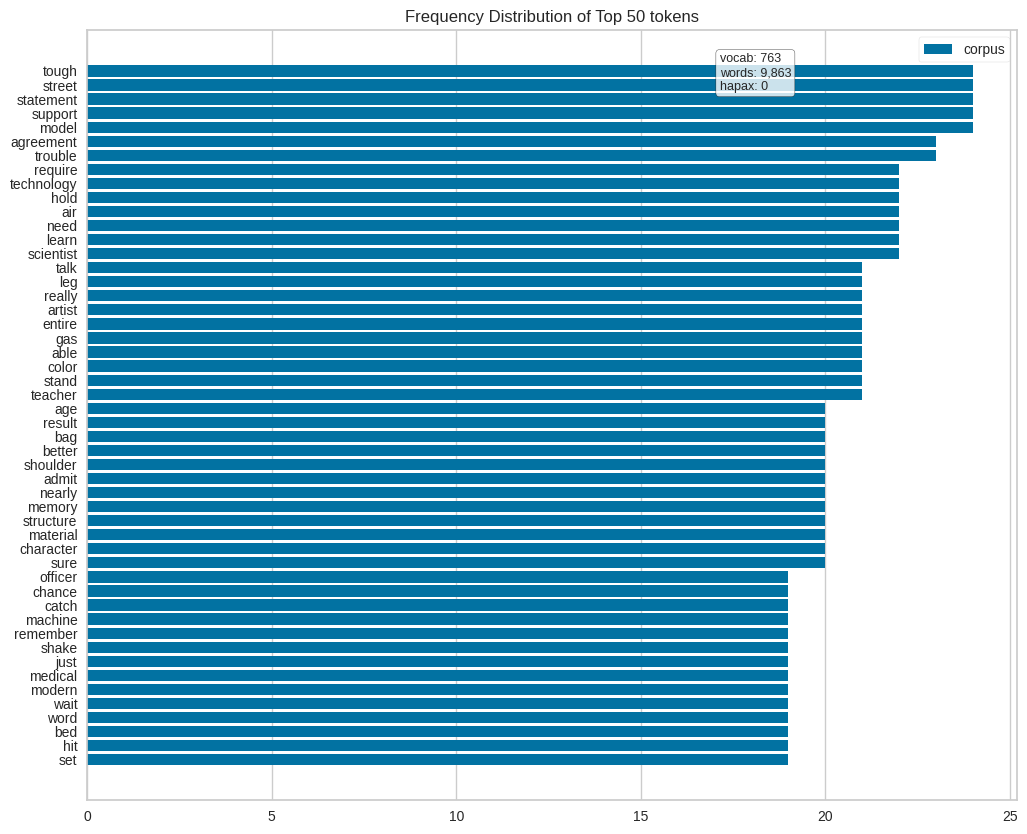

OK (1.3s)
  TSNEVisualizer... 

/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/yellowbrick/text/tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


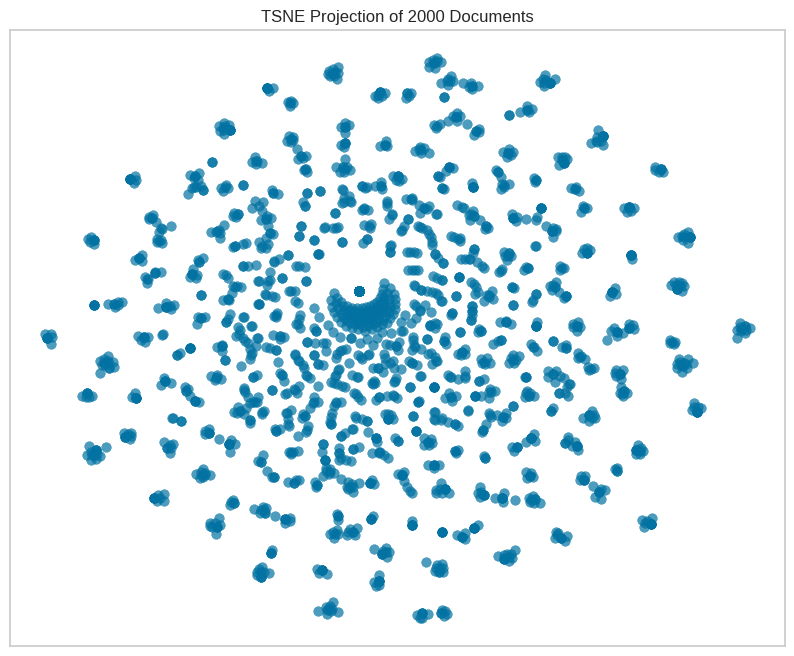

OK (55.5s)
  DispersionPlot... 

/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/yellowbrick/text/dispersion.py:290: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


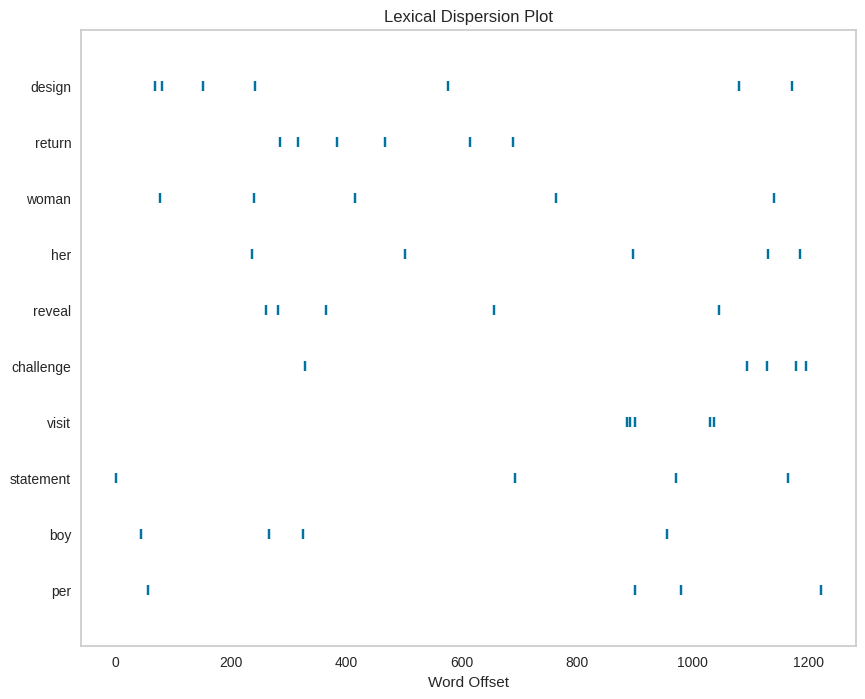

OK (0.5s)
  WordCorrelationPlot... 

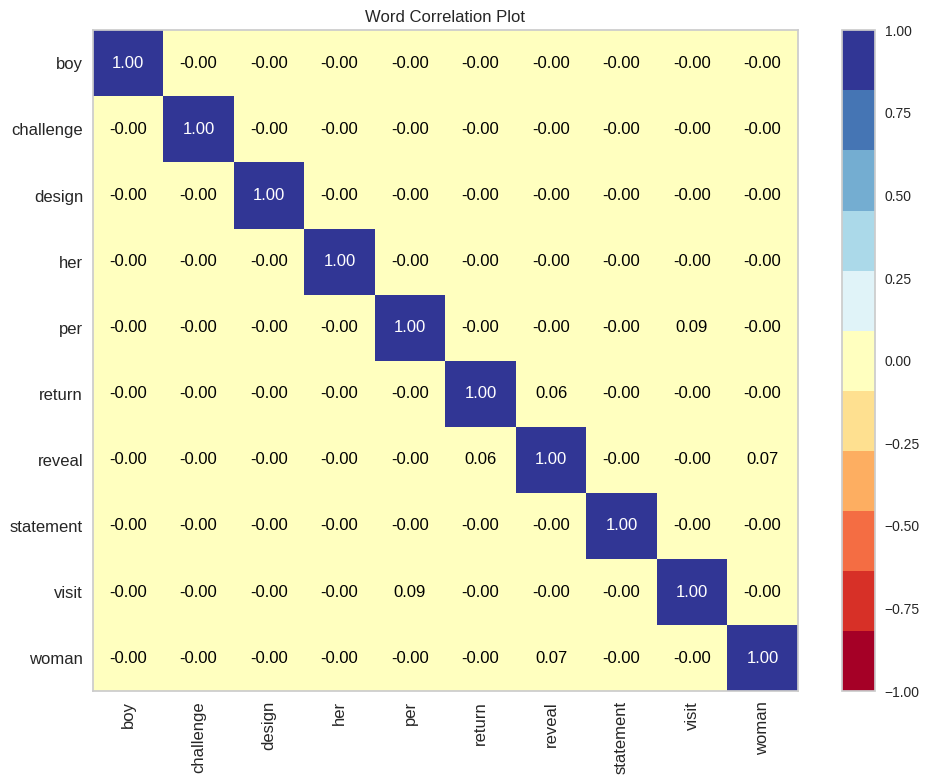

OK (2.1s)
  PosTagVisualizer... 

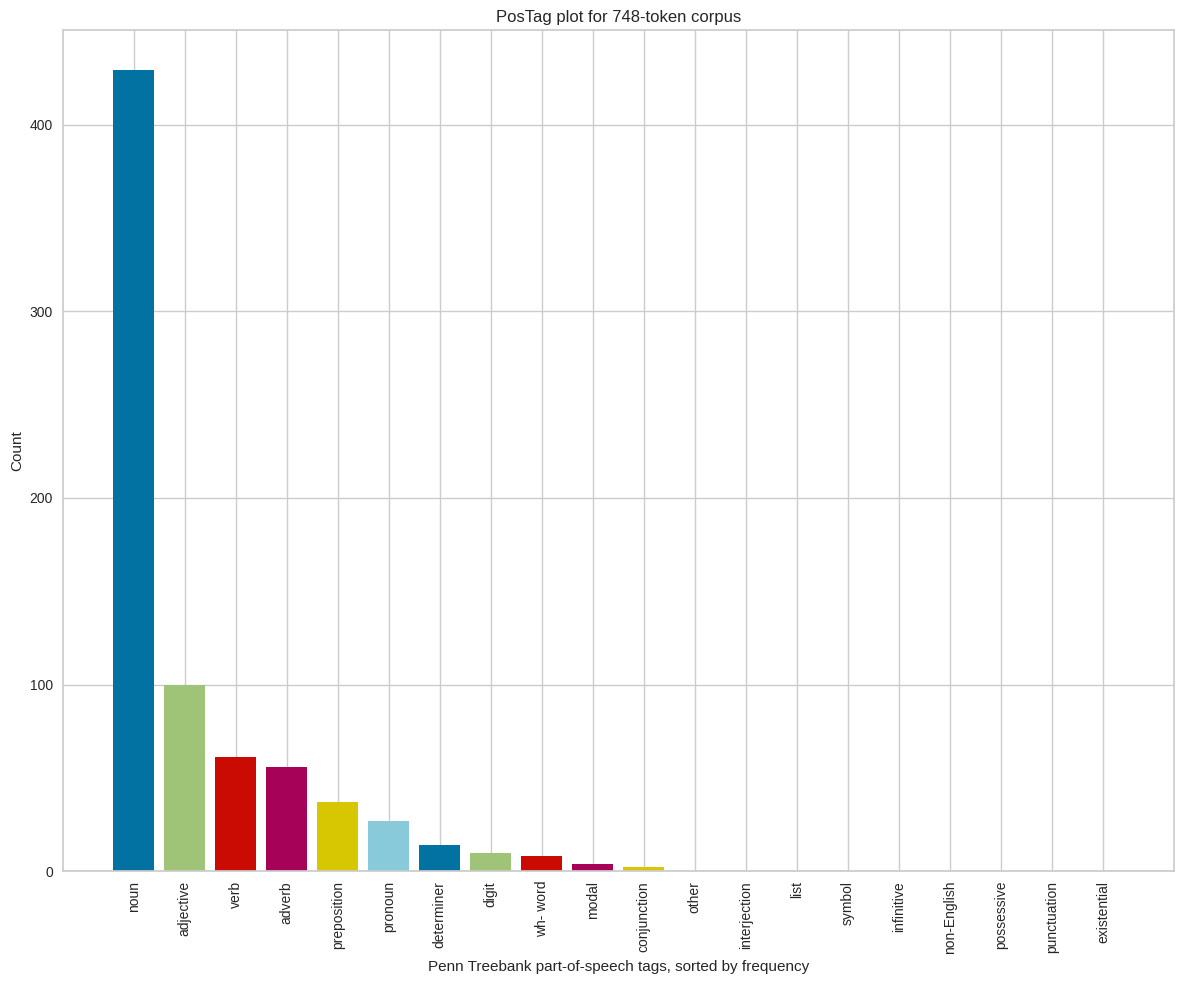

OK (2.2s)
  UMAPVisualizer... 

/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/yellowbrick/text/umap_vis.py:359: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


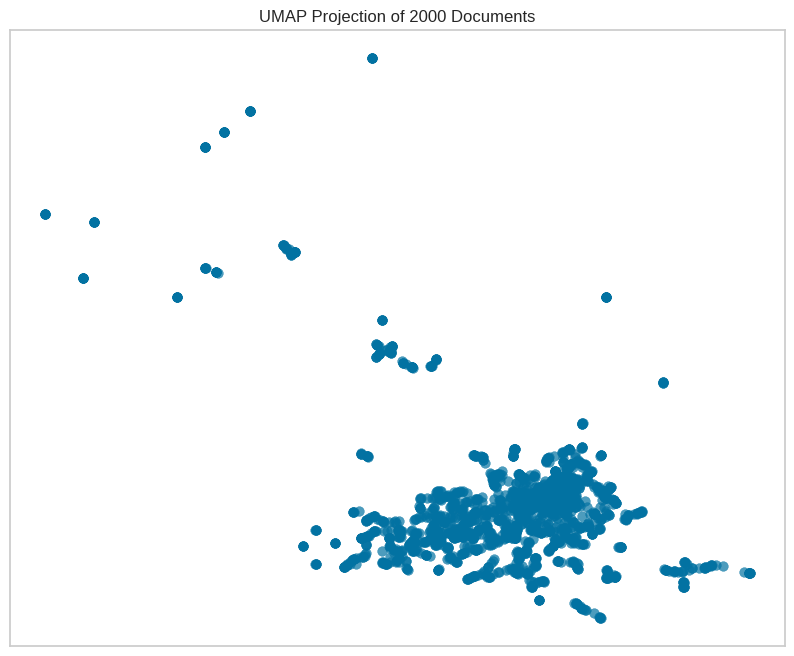

OK (35.7s)

Text Analysis Visualizers Summary:
----------------------------------------
  ✓ FreqDistVisualizer: SUCCESS (1.3s)
      → models/yellowbrick/ecci/text_analysis/FreqDistVisualizer.png
  ✓ TSNEVisualizer: SUCCESS (55.5s)
      → models/yellowbrick/ecci/text_analysis/TSNEVisualizer.png
  ✓ DispersionPlot: SUCCESS (0.5s)
      → models/yellowbrick/ecci/text_analysis/DispersionPlot.png
  ✓ WordCorrelationPlot: SUCCESS (2.1s)
      → models/yellowbrick/ecci/text_analysis/WordCorrelationPlot.png
  ✓ PosTagVisualizer: SUCCESS (2.2s)
      → models/yellowbrick/ecci/text_analysis/PosTagVisualizer.png
  ✓ UMAPVisualizer: SUCCESS (35.7s)
      → models/yellowbrick/ecci/text_analysis/UMAPVisualizer.png


In [28]:
# Prepare text data
search_queries = df_text['search_query'].dropna().tolist()
print(f"Total search queries: {len(search_queries)}")
print(f"Sample queries: {search_queries[:5]}")

# Execute text analysis visualizers
print("\nExecuting Text Analysis Visualizers:")
print("-" * 40)
text_results = execute_text_visualizers(
    text_kwargs, search_queries, verbose=True
)

# Show results summary
print("\nText Analysis Visualizers Summary:")
print("-" * 40)
for r in text_results:
    status_icon = "✓" if r["status"] == "SUCCESS" else "✗"
    print(f"  {status_icon} {r['name']}: {r['status']} ({r['time']:.1f}s)")
    if r["output"]:
        print(f"      → {r['output']}")

---

## Final Summary

### All YellowBrick Visualizers Executed

In [29]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

# Combine all results
all_results = (
    clustering_results + 
    feature_results + 
    target_results + 
    model_selection_results + 
    text_results
)

# Count by status
success_count = sum(1 for r in all_results if r["status"] == "SUCCESS")
failed_count = sum(1 for r in all_results if r["status"] == "FAILED")
skipped_count = sum(1 for r in all_results if r["status"] == "SKIPPED")
total_time = sum(r["time"] for r in all_results)

print("=" * 60)
print("YELLOWBRICK VISUALIZERS SUMMARY")
print("=" * 60)
print(f"  Total Visualizers: {len(all_results)}")
print(f"  Successful: {success_count}")
print(f"  Skipped: {skipped_count}")
print(f"  Failed: {failed_count}")
print(f"  Total Time: {total_time:.1f}s")

print(f"\nOutput Directory: {YELLOWBRICK_PATH.absolute()}")

# Group by category
print("\nResults by Category:")
print("-" * 40)
categories = [
    ("Clustering", clustering_results),
    ("Feature Analysis", feature_results),
    ("Target/Cluster Analysis", target_results),
    ("Model Selection", model_selection_results),
    ("Text Analysis", text_results),
]
for cat_name, cat_results in categories:
    success = sum(1 for r in cat_results if r["status"] == "SUCCESS")
    total = len(cat_results)
    print(f"  {cat_name}: {success}/{total}")

print("\nGenerated Files:")
for r in all_results:
    if r["output"]:
        status_icon = "✓" if r["status"] == "SUCCESS" else ("○" if r["status"] == "SKIPPED" else "✗")
        print(f"  {status_icon} {r['output']}")

# Show skipped visualizers
if skipped_count > 0:
    print("\nSkipped Visualizers:")
    for r in all_results:
        if r["status"] == "SKIPPED":
            print(f"  ○ {r['name']}: {r['error']}")

# Show failed visualizers if any
if failed_count > 0:
    print("\nFailed Visualizers:")
    for r in all_results:
        if r["status"] == "FAILED":
            print(f"  ✗ {r['name']}: {r['error']}")

YELLOWBRICK VISUALIZERS SUMMARY
  Total Visualizers: 24
  Successful: 24
  Skipped: 0
  Failed: 0
  Total Time: 271.0s

Output Directory: /home/rafaelcoelho/Workbench/COELHORealTime/notebooks/models/yellowbrick/ecci

Results by Category:
----------------------------------------
  Clustering: 3/3
  Feature Analysis: 7/7
  Target/Cluster Analysis: 4/4
  Model Selection: 4/4
  Text Analysis: 6/6

Generated Files:
  ✓ models/yellowbrick/ecci/clustering/KElbowVisualizer.png
  ✓ models/yellowbrick/ecci/clustering/SilhouetteVisualizer.png
  ✓ models/yellowbrick/ecci/clustering/InterclusterDistance.png
  ✓ models/yellowbrick/ecci/feature_analysis/Rank1D.png
  ✓ models/yellowbrick/ecci/feature_analysis/Rank2D.png
  ✓ models/yellowbrick/ecci/feature_analysis/PCA.png
  ✓ models/yellowbrick/ecci/feature_analysis/Manifold.png
  ✓ models/yellowbrick/ecci/feature_analysis/ParallelCoordinates.png
  ✓ models/yellowbrick/ecci/feature_analysis/RadViz.png
  ✓ models/yellowbrick/ecci/feature_analysis/Joint

In [30]:
# =============================================================================
# CLUSTERING MODEL SUMMARY
# =============================================================================

print("=" * 60)
print("CLUSTERING SUMMARY")
print("=" * 60)
print(f"Model: {MODEL_TYPE}")
print(f"Optimal K: {OPTIMAL_K}")
print(f"Events: {len(df_original):,}")
print(f"\nMetrics:")
for name, value in metrics_to_log.items():
    print(f"  {name}: {value:.4f}")
print(f"\nCluster Distribution:")
for c in sorted(df_original['cluster'].unique()):
    n = (df_original['cluster'] == c).sum()
    print(f"  Cluster {c}: {n:,} ({n/len(df_original)*100:.1f}%)")

print(f"\nCluster Profiles (Event-Level Features):")
profiles[['price', 'quantity', 'time_on_page_seconds', 'event_type', 'cluster_size', 'cluster_pct']]

CLUSTERING SUMMARY
Model: kmeans
Optimal K: 2
Events: 10,000

Metrics:
  silhouette_score: 0.1526
  calinski_harabasz_score: 1509.8047
  davies_bouldin_score: 2.2917
  inertia: 95568.1846

Cluster Distribution:
  Cluster 0: 6,944 (69.4%)
  Cluster 1: 3,056 (30.6%)

Cluster Profiles (Event-Level Features):


,price,quantity,time_on_page_seconds,event_type,cluster_size,cluster_pct
cluster,,,,,,
0,1237.454423,0.251584,146.068404,2.09375,6944,69.4
1,1238.547798,2.497382,151.403141,0.00000,3056,30.6
